In [57]:
#############################################################
##https://github.com/makezur/information_bottleneck_pytorch##
#############################################################
##下面程序是我把上面这个网站的程序集合到一个jupyter notebook文件而已
##替换tanh的7层12*10*7*5*4*3*1全连接网络激活函数层
##tanh是对称饱和型激活函数，我们也自定义一个试试。
##I(X,T)下降到1.22147935
##I(Y,T)增加到0.99471089
##比tanh激活函数好，这个激活函数是GEU的变种，即2*(GEU-0.5)，其内核还是高斯误差函数
  
import numpy as np
import torch
from torch import nn
import tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

import scipy.io as sio
import math

In [58]:
def load_tishby_toy_dataset(filename, assign_random_labels=False, seed=42):
    np.random.seed(seed)
    
    data = sio.loadmat(filename)
    F = data['F']
    
    if assign_random_labels:
        y = np.random.randint(0, 2)
    else:
        y = data['y'].T
    
    return F, y

In [59]:
class BatchGenerator():
    def __init__(self, inputs_list, batch_size, seed=None):
        self.inputs_list = inputs_list
        self.batch_size = batch_size
        self.seed = seed
    
        self.indices = np.arange(self.inputs_list[0].shape[0])
        np.random.seed(self.seed)   
        np.random.shuffle(self.indices)

    def how_it_shuffled(self):
        return [current_input[self.indices] for current_input in self.inputs_list], np.arange(len(self.indices))[self.indices]

    def batch_generator(self):
        assert(len(self.inputs_list) > 0)
        
        
        for input_array in self.inputs_list:
            assert(input_array.shape[0] == self.inputs_list[0].shape[0])
            
        data_size = self.inputs_list[0].shape[0] // self.batch_size
        
        if self.inputs_list[0].shape[0] % self.batch_size > 0:
            data_size += 1
            
        for i in range(0, data_size):
            current_indices = self.indices[i * self.batch_size: (i + 1) * self.batch_size]     
            yield [current_input[current_indices] for current_input in self.inputs_list]

In [60]:
import torch
import torch.nn as nn
import numpy as np

# Define custom activation functions
class CustomActivation0(nn.Module):
    def __init__(self):
        super(CustomActivation0, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        #x = torch.erf(input / self.sigma)
        x = (torch.exp(2*input / self.sigma)-1) / (torch.exp(2*input / self.sigma)+1)
        return x

class CustomActivation1(nn.Module):
    def __init__(self):
        super(CustomActivation1, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        #x = torch.erf(input / self.sigma)
        x = (torch.exp(2*input / self.sigma)-1) / (torch.exp(2*input / self.sigma)+1)
        return x

class CustomActivation2(nn.Module):
    def __init__(self):
        super(CustomActivation2, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        #x = torch.erf(input / self.sigma)
        x = (torch.exp(2*input / self.sigma)-1) / (torch.exp(2*input / self.sigma)+1)
        return x

class CustomActivation3(nn.Module):
    def __init__(self):
        super(CustomActivation3, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        #x = torch.erf(input / self.sigma)
        x = (torch.exp(2*input / self.sigma)-1) / (torch.exp(2*input / self.sigma)+1)
        return x

class CustomActivation4(nn.Module):
    def __init__(self):
        super(CustomActivation4, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        #x = torch.erf(input / self.sigma)
        x = (torch.exp(2*input / self.sigma)-1) / (torch.exp(2*input / self.sigma)+1)
        return x


class CustomActivation5(nn.Module):
    def __init__(self):
        super(CustomActivation5, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        #x = torch.erf(input / self.sigma)
        x = (torch.exp(2*input / self.sigma)-1) / (torch.exp(2*input / self.sigma)+1)
        return x 
        
class MLPWithInfo(nn.Module):
    def __init__(self, input_dim=12, layers_dim=[10, 7, 5, 4, 3, 1], 
                 activations=[CustomActivation0, CustomActivation1, CustomActivation2, CustomActivation3, CustomActivation4],
                 output_activation=CustomActivation5, last_activation=None):
        super().__init__()
        self.representations_per_epochs = []
        self.info_layers_numbers = []
        layers_dims = [input_dim] + layers_dim
        self.has_output_activation = output_activation is not None
        self.last_activation = last_activation

        layers = []
        
        current_layer = -1
        for i in range(len(layers_dims) - 1):
            layers.append(nn.Linear(layers_dims[i], layers_dims[i + 1]))
            current_layer += 1
            if i < len(layers_dims) - 2:
                layers.append(activations[i]())
                current_layer += 1
                self.info_layers_numbers.append(current_layer)
            elif self.has_output_activation:
                layers.append(output_activation())
                current_layer += 1
                self.info_layers_numbers.append(current_layer)

        #print(f"info_layers_numbers: {self.info_layers_numbers}")
                 
        self.model = nn.ModuleList(layers)
        self.current_representations = None
        self.reset()
        
    def forward(self, x):
        current_representation = x
        next_layer_index = 0

        for i, layer in enumerate(self.model):
            current_representation = layer(current_representation)
            #print(f"Layer {i}: {layer}, Current Representation Shape: {current_representation.shape}")

            if next_layer_index < len(self.info_layers_numbers) and i == self.info_layers_numbers[next_layer_index]:
                self.add_info(next_layer_index, current_representation.detach().numpy())
                next_layer_index += 1

        if not self.has_output_activation and self.last_activation is not None:
            self.add_info(next_layer_index, self.last_activation()(current_representation).detach().numpy())
        elif self.has_output_activation:
            self.add_info(next_layer_index, current_representation.detach().numpy())

        return current_representation

    def next_epoch(self):
        self.representations_per_epochs.append(self.current_representations)
        self.reset()

    def add_info(self, layer_index, representations):
        #print(f"Adding info to layer {layer_index} with shape {representations.shape}")  # 添加调试信息
        if layer_index >= len(self.current_representations):
            raise IndexError(f"layer_index {layer_index} is out of range for current_representations with length {len(self.current_representations)}")

        if self.current_representations[layer_index] is None:
            self.current_representations[layer_index] = representations
        else:
            self.current_representations[layer_index] = np.concatenate([self.current_representations[layer_index],
                                                                       representations], axis=0)

    def reset(self):
        self.current_representations = [None for _ in range(len(self.info_layers_numbers))]
        #print(f"Reset current_representations to length {len(self.current_representations)}")



In [61]:
def train_network(model, X, y, X_val, y_val, batch_size=12, epochs=16):
    """
    The network is trained with full batch
    """
    loss_list = []
    epoch_mean_loss = []
    accuracy_mean_val = []
    sigma_value1 = []
    sigma_value3 = []
    sigma_value5 = []
    sigma_value7 = []
    sigma_value9 = []
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
    loss_fun = nn.BCEWithLogitsLoss()
    model.reset()
    train_shuffles = []

    for epoch in tqdm.tqdm(range(epochs)):
        samples = 0
        cum_loss = 0

        model.reset()

        train_batcher = BatchGenerator([X, y], batch_size)
        train_shuffles.append(train_batcher.how_it_shuffled()[1])

        for X_batch, y_batch in train_batcher.batch_generator():
            X_batch = torch.Tensor(X_batch)
            y_batch = torch.Tensor(y_batch)

            model.train()
            predictions = model(X_batch)

            loss = loss_fun(predictions.reshape(-1), y_batch.reshape(-1))
            loss.backward()

            loss_list.append(loss.item())

            optimizer.step()
            optimizer.zero_grad()

            samples += X_batch.shape[0]
            cum_loss += loss.item()

        scheduler.step()
        model.next_epoch()

        epoch_mean_loss.append(cum_loss / samples)
        sigma_value1.append(model.model[1].sigma.item())
        sigma_value3.append(model.model[3].sigma.item())
        sigma_value5.append(model.model[5].sigma.item())
        sigma_value7.append(model.model[7].sigma.item())
        sigma_value9.append(model.model[9].sigma.item())
        samples_val = 0
        accuracy_val = 0

        val_batcher = BatchGenerator([X_val, y_val], 1)

        for X_batch, y_batch in val_batcher.batch_generator():
            X_batch = torch.Tensor(X_batch)
            y_batch = torch.Tensor(y_batch)

            model.eval()
            predictions_logits = model(X_batch)

            accuracy_val += (y_batch.int() == (torch.nn.functional.sigmoid(predictions_logits) > 0.5).int()).sum().item()
            samples_val += X_batch.shape[0]

        accuracy_mean_val.append(float(accuracy_val) / samples_val)

    return epoch_mean_loss, accuracy_mean_val, train_shuffles,sigma_value1,sigma_value3,sigma_value5,sigma_value7,sigma_value9

In [62]:
def get_aligned_representations(representations, order):
    for epoch in range(len(representations)):
        for layer in range(len(representations[0])):
            representations[epoch][layer] = representations[epoch][layer][np.argsort(order[epoch]), :]

    return representations

In [63]:
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import warnings
import numpy as np
import numba

NUM_CORES = cpu_count()
warnings.filterwarnings("ignore")

In [64]:
def entropy(probs):
    return -np.sum(probs * np.ma.log2(probs))

def joint_entropy(unique_inverse_x, unique_inverse_y, bins_x, bins_y):

    joint_distribution = np.zeros((bins_x, bins_y))
    np.add.at(joint_distribution, (unique_inverse_x, unique_inverse_y), 1)
    joint_distribution /= np.sum(joint_distribution)

    return entropy(joint_distribution)


def layer_information(layer_output, bins, py, px, unique_inverse_x, unique_inverse_y):
    ws_epoch_layer_bins = bins[np.digitize(layer_output, bins) - 1]
    ws_epoch_layer_bins = ws_epoch_layer_bins.reshape(len(layer_output), -1)

    unique_t, unique_inverse_t, unique_counts_t = np.unique(
        ws_epoch_layer_bins, axis=0,
        return_index=False, return_inverse=True, return_counts=True
    )

    pt = unique_counts_t / np.sum(unique_counts_t)

    # # I(X, Y) = H(Y) - H(Y|X)
    # # H(Y|X) = H(X, Y) - H(X)

    x_entropy = entropy(px)
    y_entropy = entropy(py)
    t_entropy = entropy(pt)

    x_t_joint_entropy = joint_entropy(unique_inverse_x, unique_inverse_t, px.shape[0], layer_output.shape[0])
    y_t_joint_entropy = joint_entropy(unique_inverse_y, unique_inverse_t, py.shape[0], layer_output.shape[0])

    return {
        'local_IXT': t_entropy + x_entropy - x_t_joint_entropy,
        'local_ITY': y_entropy + t_entropy - y_t_joint_entropy
    }


def calc_information_for_epoch(epoch_number, ws_epoch, bins, unique_inverse_x,
                               unique_inverse_y, pxs, pys):
    """Calculate the information for all the layers for specific epoch"""
    information_epoch = []

    for i in range(len(ws_epoch)):
        information_epoch_layer = layer_information(
            layer_output=ws_epoch[i],
            bins=bins,
            unique_inverse_x=unique_inverse_x,
            unique_inverse_y=unique_inverse_y,
            px=pxs, py=pys
        )
        information_epoch.append(information_epoch_layer)
    information_epoch = np.array(information_epoch)

    # print('Processed epoch {}'.format(epoch_number))

    return information_epoch


def extract_probs(label, x):
    """calculate the probabilities of the given data and labels p(x), p(y) and (y|x)"""
    pys = np.sum(label, axis=0) / float(label.shape[0])

    unique_x, unique_x_indices, unique_inverse_x, unique_x_counts = np.unique(
        x, axis=0,
        return_index=True, return_inverse=True, return_counts=True
    )

    pxs = unique_x_counts / np.sum(unique_x_counts)

    unique_array_y, unique_y_indices, unique_inverse_y, unique_y_counts = np.unique(
        label, axis=0,
        return_index=True, return_inverse=True, return_counts=True
    )
    return pys, None, unique_x, unique_inverse_x, unique_inverse_y, pxs


def get_information(ws, x, label, num_of_bins, every_n=1,
                    return_matrices=False):
    """
    Calculate the information for the network for all the epochs and all the layers

    ws.shape =  [n_epoch, n_layers, n_params]
    ws --- outputs of all layers for all epochs
    """

    # print('Start calculating the information...')

    bins = np.linspace(-1, 1, num_of_bins)
    label = np.array(label).astype(np.float)
    pys, _, unique_x, unique_inverse_x, unique_inverse_y, pxs = extract_probs(label, x)

    with Parallel(n_jobs=NUM_CORES, prefer='threads') as parallel:
        information_total = parallel(
            delayed(calc_information_for_epoch)(
                i, epoch_output, bins, unique_inverse_x, unique_inverse_y, pxs, pys
            ) for i, epoch_output in enumerate(ws) if i % every_n == 0
        )

    if not return_matrices:
        return information_total

    ixt_matrix = np.zeros((len(information_total), len(ws[0])))
    ity_matrix = np.zeros((len(information_total), len(ws[0])))

    for epoch, layer_info in enumerate(information_total):
        for layer, info in enumerate(layer_info):
            ixt_matrix[epoch][layer] = info['local_IXT']
            ity_matrix[epoch][layer] = info['local_ITY']

    return ixt_matrix, ity_matrix

In [65]:
model = MLPWithInfo(output_activation=None)

In [66]:
model

MLPWithInfo(
  (model): ModuleList(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): CustomActivation0()
    (2): Linear(in_features=10, out_features=7, bias=True)
    (3): CustomActivation1()
    (4): Linear(in_features=7, out_features=5, bias=True)
    (5): CustomActivation2()
    (6): Linear(in_features=5, out_features=4, bias=True)
    (7): CustomActivation3()
    (8): Linear(in_features=4, out_features=3, bias=True)
    (9): CustomActivation4()
    (10): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [67]:
X, y = load_tishby_toy_dataset('D:/深度学习与信息论/information_bottleneck_pytorch-master/data/g1.mat')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9)

In [68]:
label = np.array(y).astype(np.float)
pys, _, unique_x, unique_inverse_x, unique_inverse_y, pxs = extract_probs(label, X)
print(pys)

[0.50366211]


In [69]:
epochs = 100
train_res = train_network(model, X_train, y_train.astype(np.int),
                                          X_test, y_test.astype(np.int), batch_size=12, epochs=epochs)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


In [26]:
ws = model.representations_per_epochs
order = train_res[2]
ws = get_aligned_representations(ws, order)

In [27]:
assert len(model.representations_per_epochs) == epochs
assert len(model.representations_per_epochs[0]) == len(model.info_layers_numbers)

for i in range(len(model.representations_per_epochs[0])):
    assert(model.representations_per_epochs[0][i].shape[0] == X_train.shape[0])

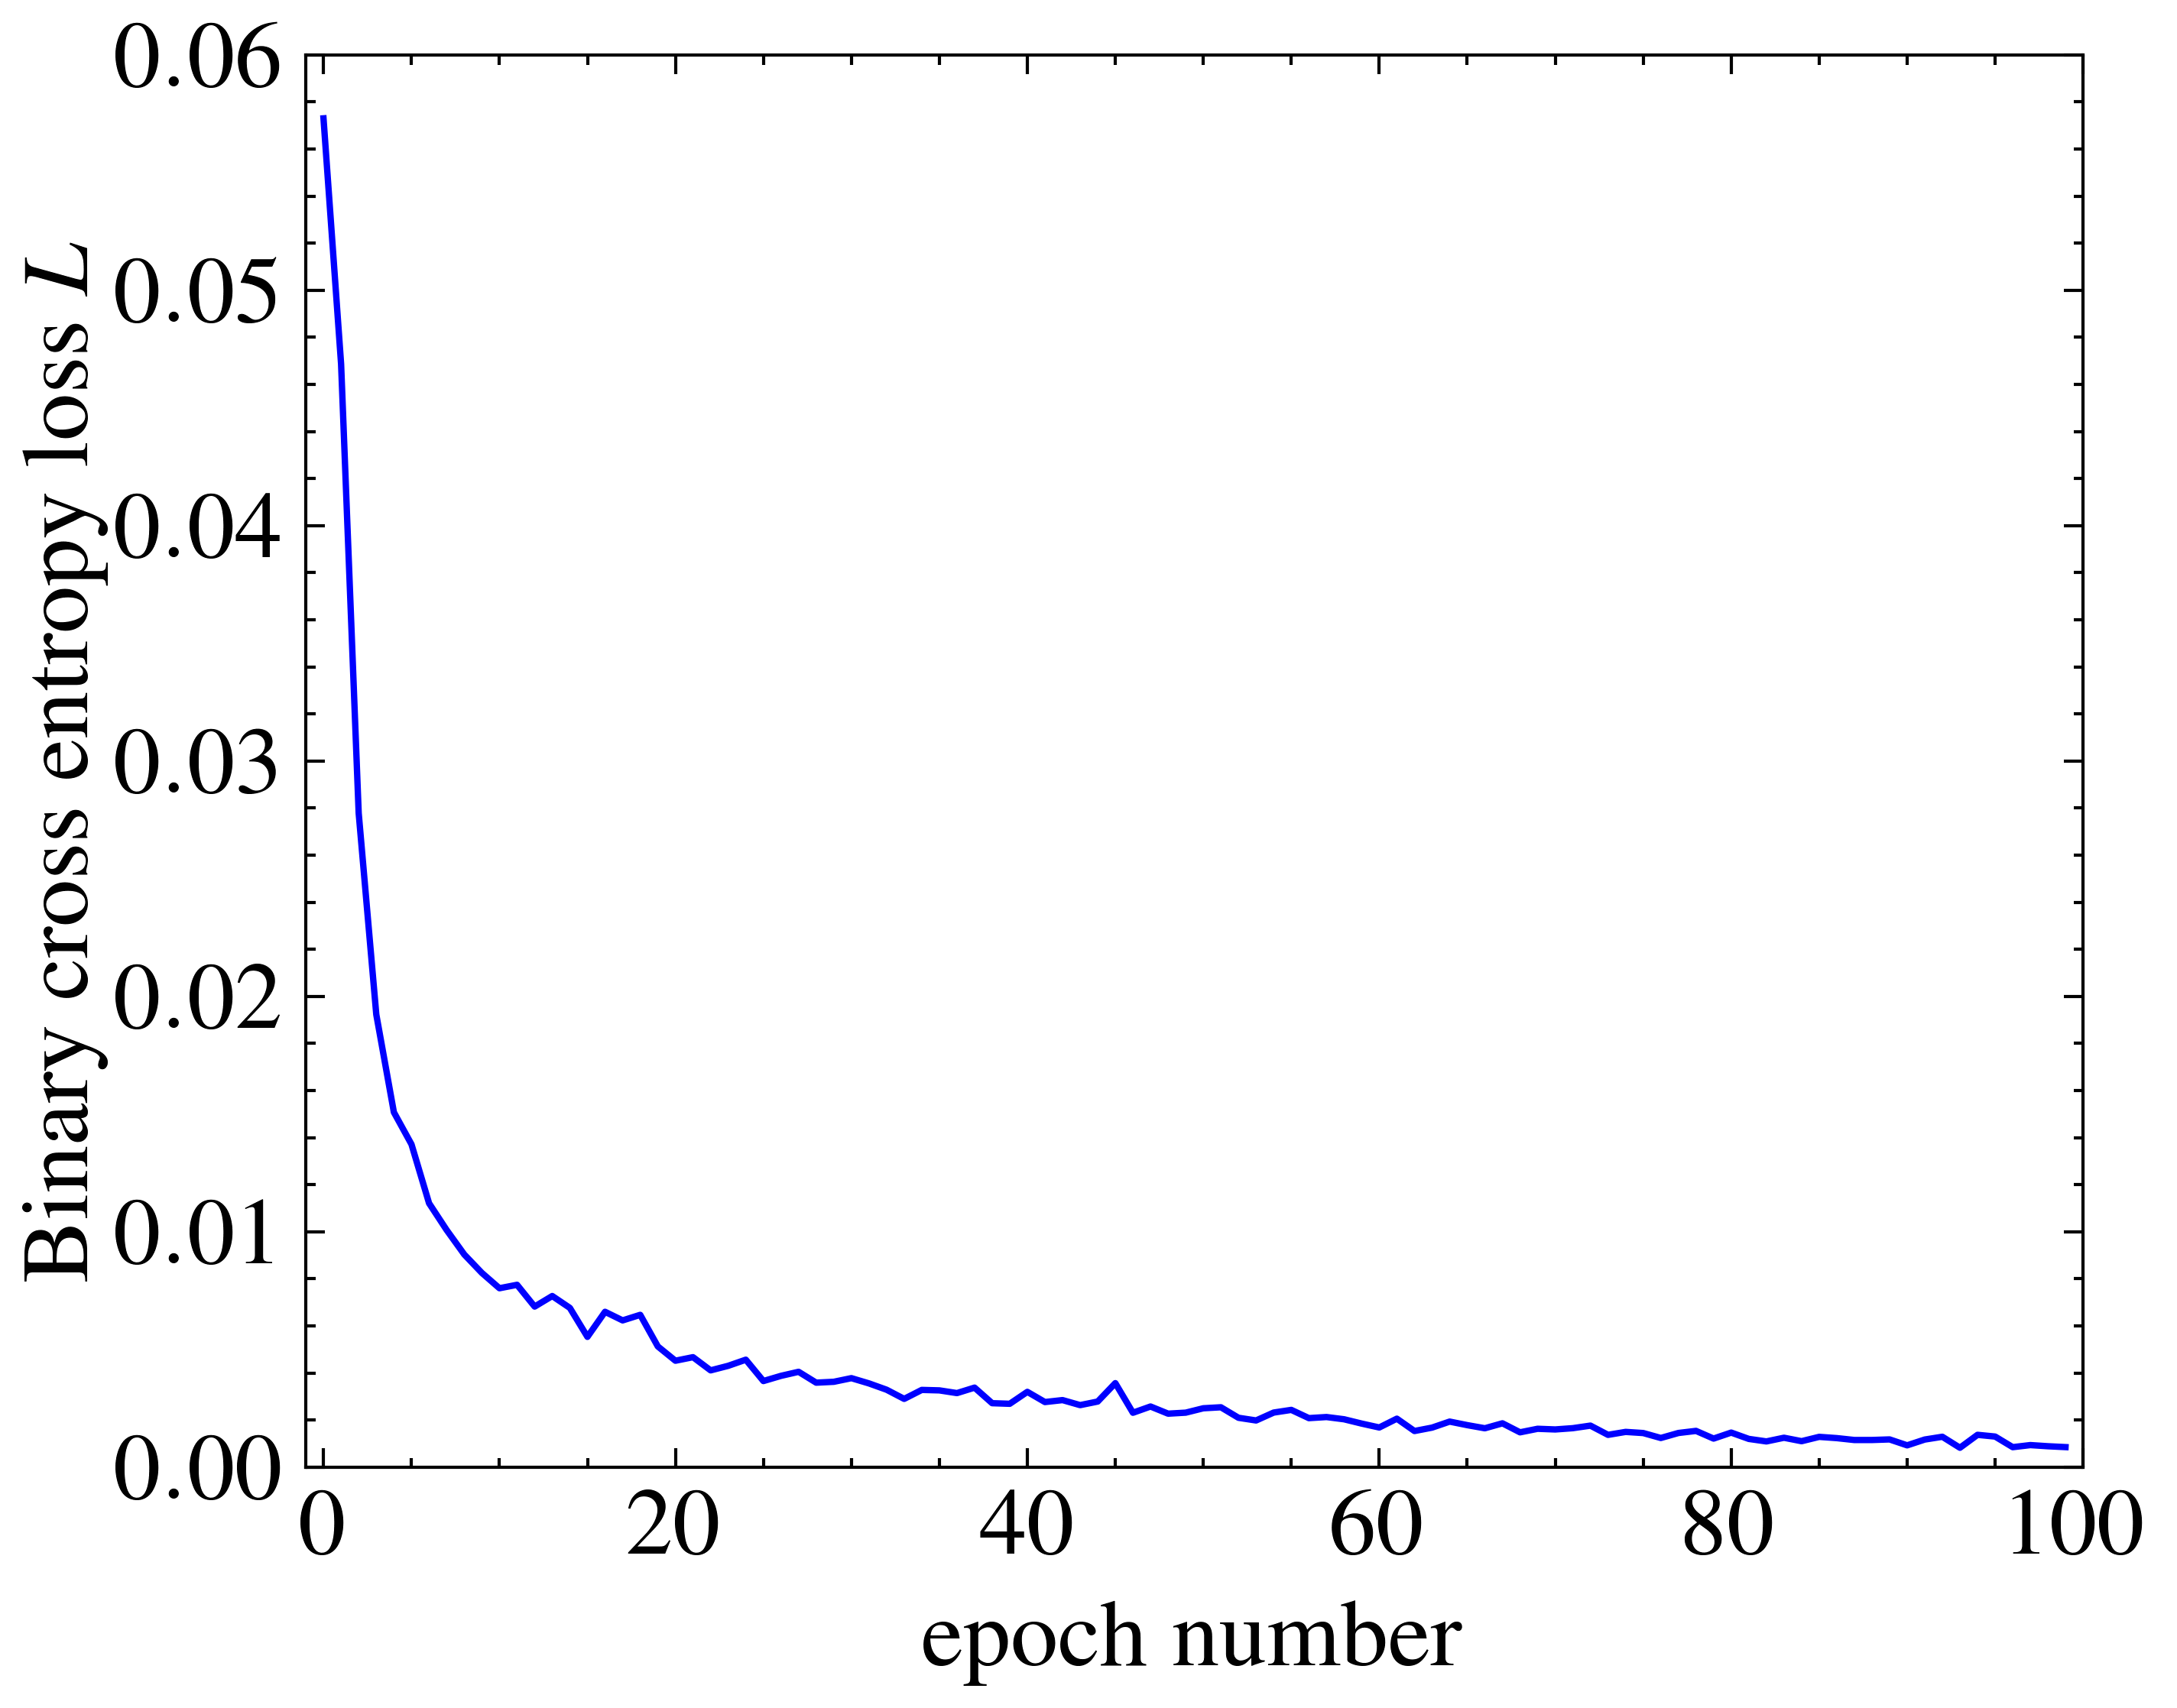

In [75]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('Binary cross entropy loss $L$', fontsize=15,labelpad = 1)
ax.set_xlim(-1, 100)
ax.set_ylim(0, 0.06)

plt.plot(np.arange(len(train_res[0])), train_res[0],'b-', lw=1)

ax.legend(loc='upper right', fontsize=15)

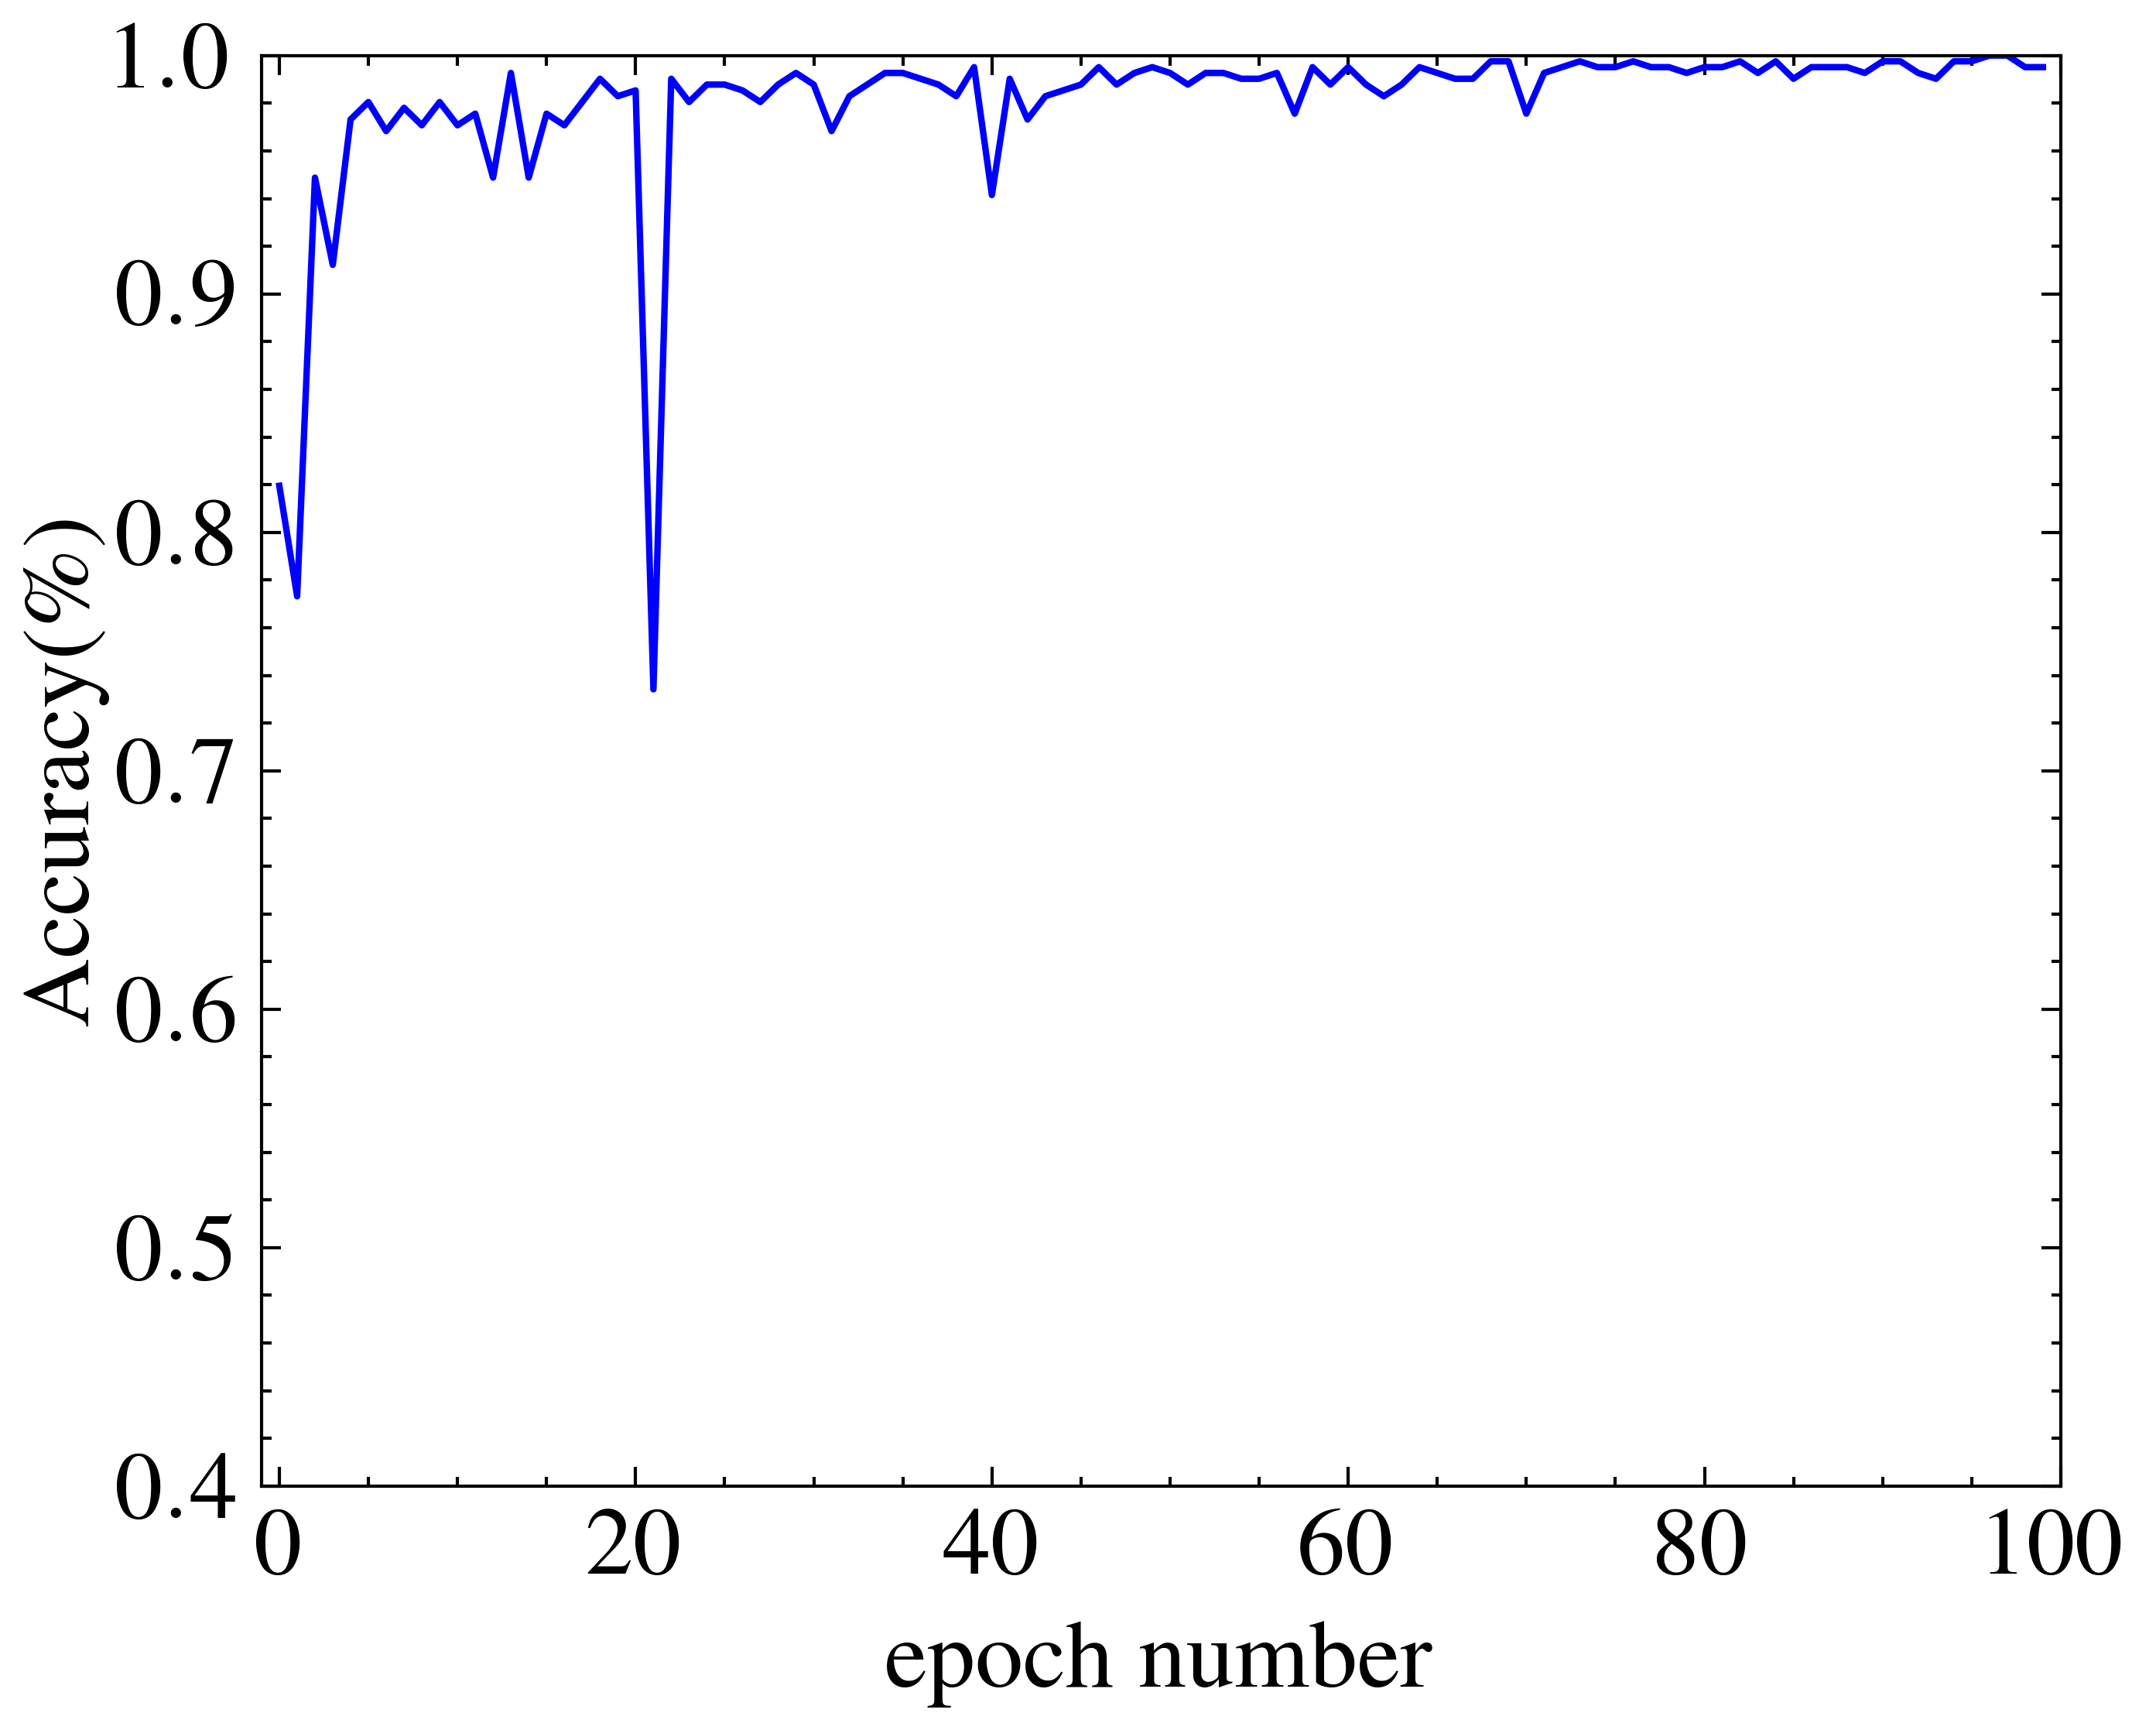

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('Accuracy(\%)', fontsize=15,labelpad = 1)
ax.set_xlim(-1, 100)
ax.set_ylim(0.4, 1)

plt.plot(np.arange(len(train_res[0])), train_res[1],'b-', lw=1)

ax.legend(loc='upper right', fontsize=15)

plt.show()

In [30]:
num_of_bins = 40
every_n = 10
IXT_array, ITY_array = get_information(ws, X_train, np.concatenate([y_train, 1 - y_train], axis=1), 
                                       num_of_bins, every_n=every_n, return_matrices=True)

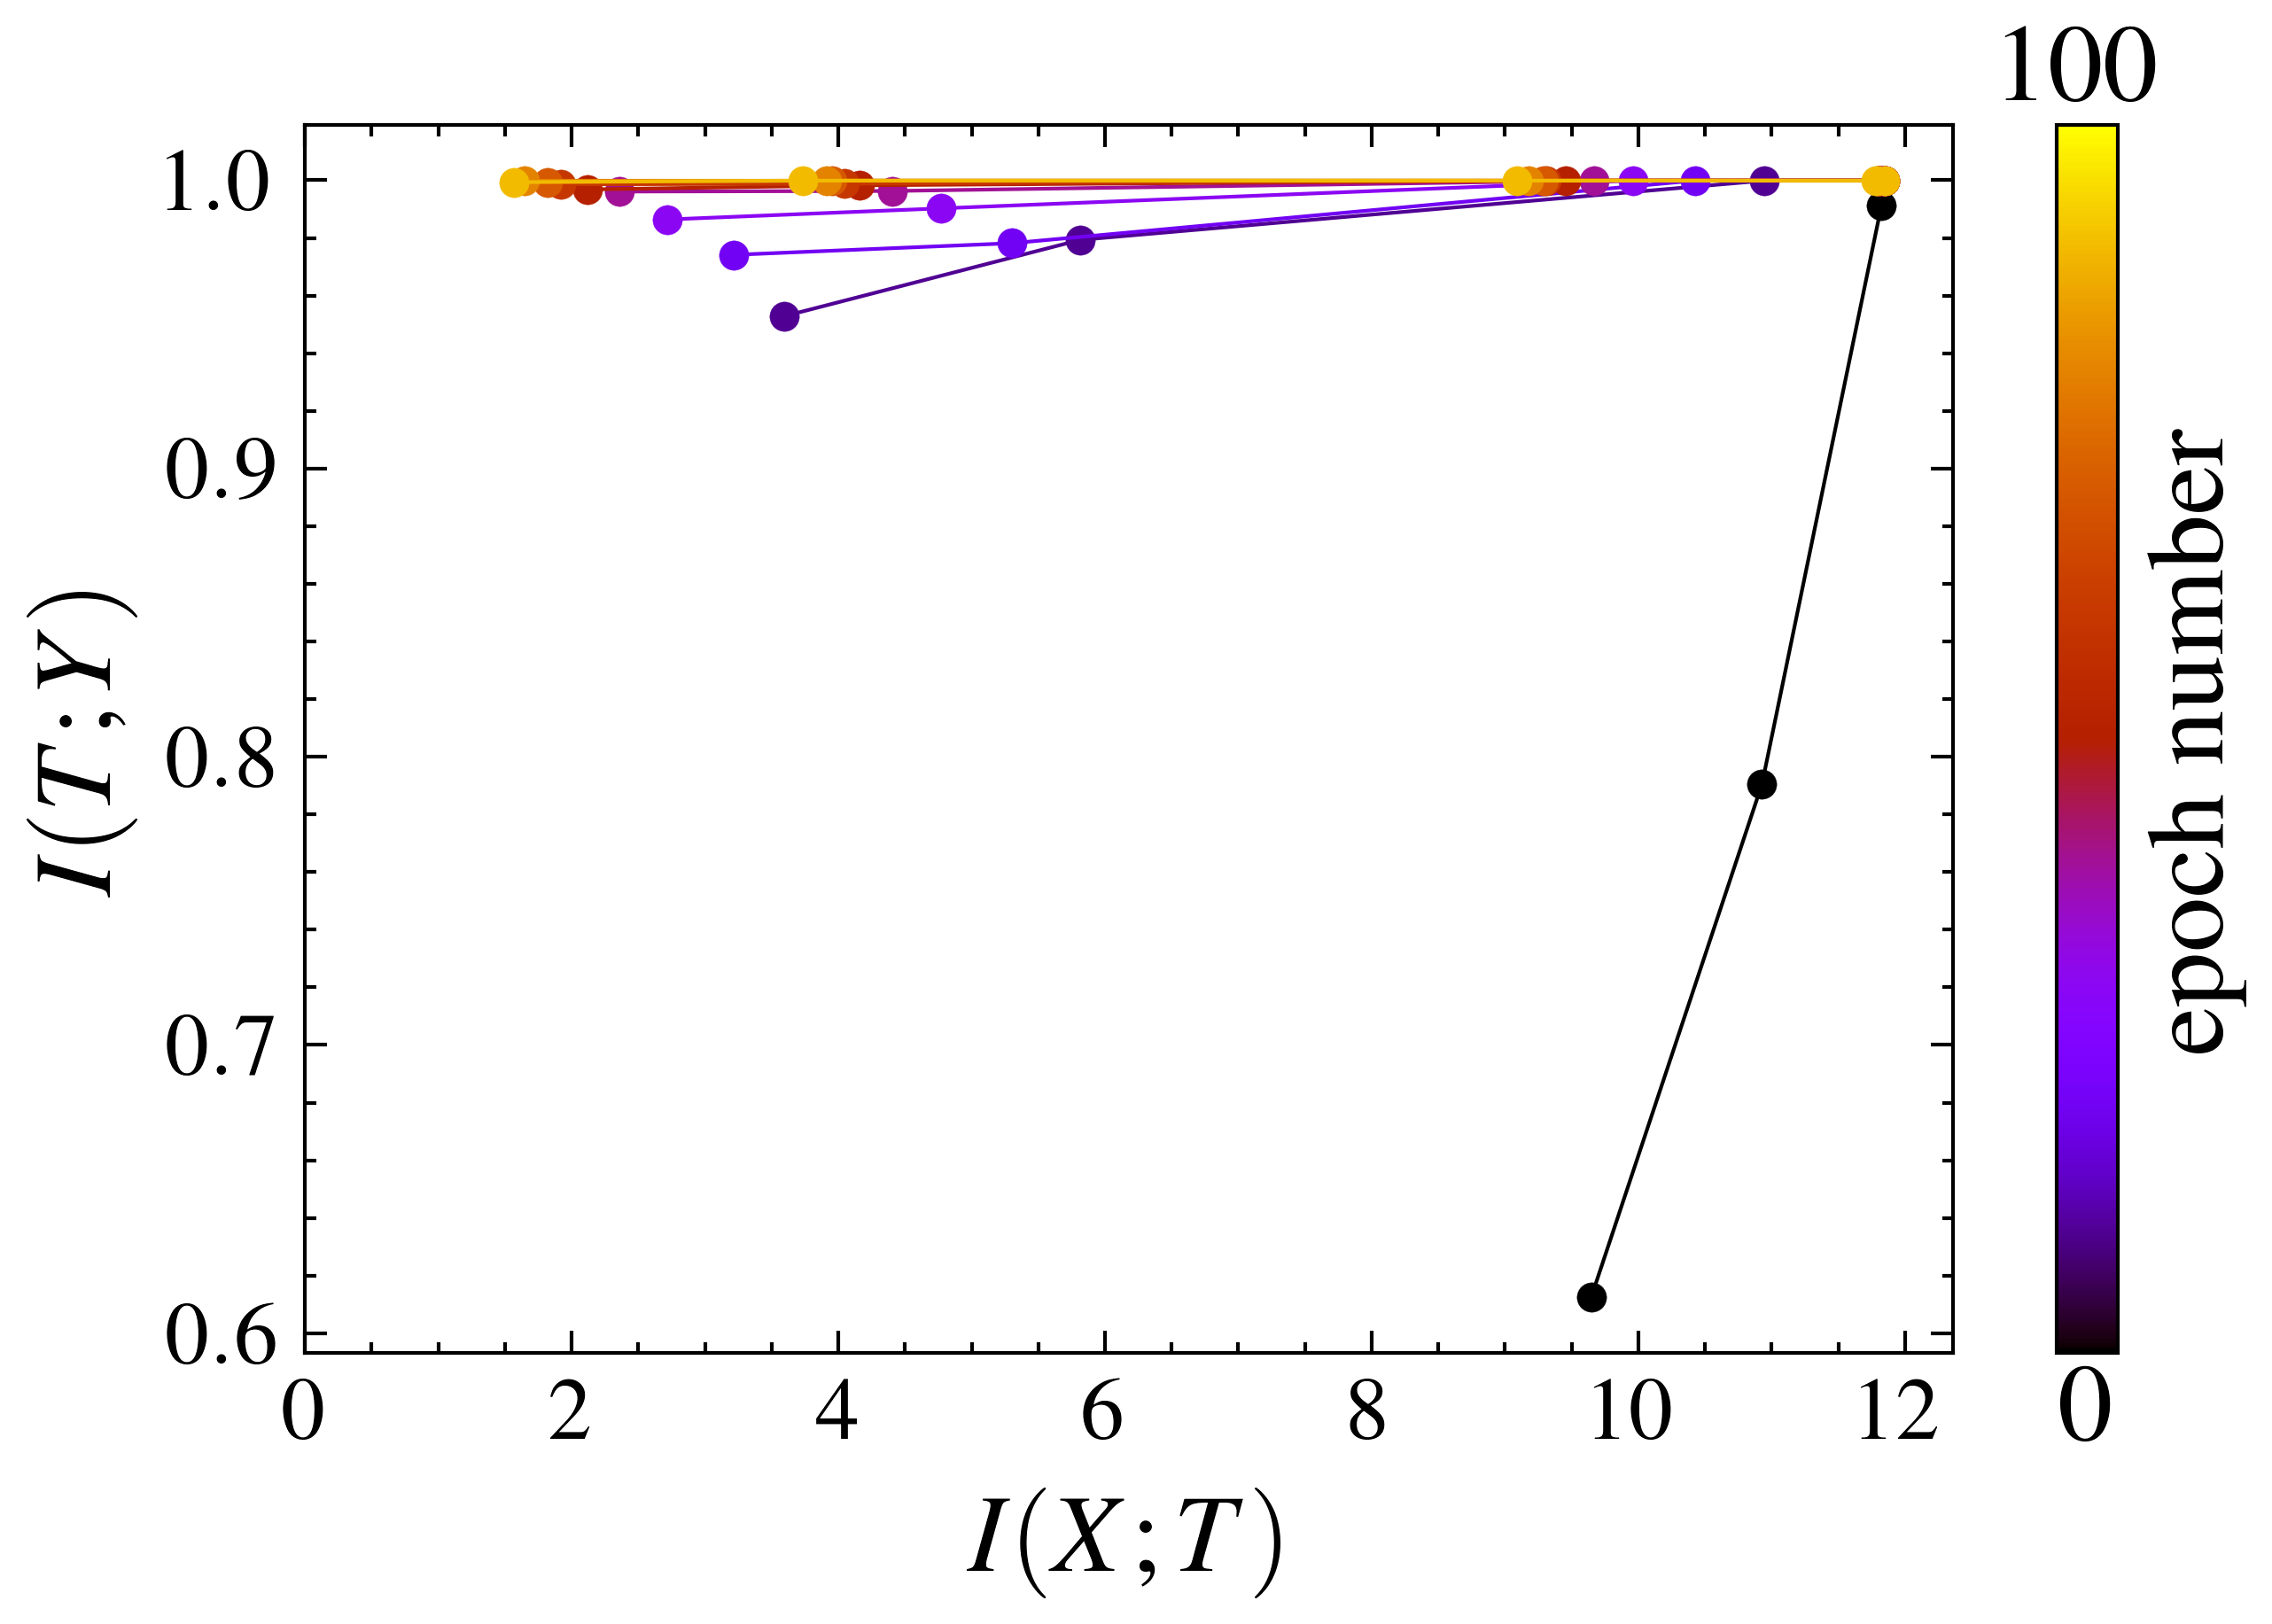

In [39]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    plt.figure(figsize=(5, 3))
    plt.xlabel('$I(X;T)$', fontsize=15)
    plt.ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        plt.plot(IXT, ITY, marker='o', markersize=4, markeredgewidth=0.04,
                 linestyle='-', linewidth=0.5, color=colors[i * every_n], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=plt.gca(), ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks([0, 2, 4, 6, 8, 10, 12])
    ax.text(-5, 0.98, '(b)',fontdict={'size': 15, 'color':  'black'})
    fig.savefig('D:/深度学习与信息论/Fig5b.eps', dpi=800)
    plt.show()

plot_information_plane(IXT_array, ITY_array, num_epochs=epochs, every_n=every_n)

In [32]:
print(IXT_array)

[[11.84784036 11.84784036 11.82342364 10.92789325  9.64765102]
 [11.84784036 11.84784036 10.94711815  5.81594628  3.59226824]
 [11.84784036 11.84241442 10.42368526  5.30145611  3.21810585]
 [11.84784036 11.8353607   9.9606935   4.76735231  2.7175341 ]
 [11.84784036 11.8182637   9.66532615  4.40619296  2.35922143]
 [11.84784036 11.81310376  9.45806956  4.15747351  2.1175928 ]
 [11.84784036 11.80245668  9.30710942  4.04427742  1.91765224]
 [11.84784036 11.80374667  9.29249926  3.95482378  1.81706224]
 [11.84784036 11.79081972  9.17834093  3.91086306  1.6453653 ]
 [11.84784036 11.7840697   9.08926868  3.73245144  1.56381305]]


In [33]:
print(ITY_array)

[[0.99988765 0.99988765 0.99120616 0.79055283 0.61258222]
 [0.99988765 0.99988765 0.99988765 0.97934442 0.95282683]
 [0.99988765 0.99988765 0.99988765 0.9781733  0.97414325]
 [0.99988765 0.99988765 0.99988765 0.99025396 0.98640004]
 [0.99988765 0.99988765 0.99988765 0.9962943  0.9960895 ]
 [0.99988765 0.99988765 0.99988765 0.99825987 0.99682628]
 [0.99988765 0.99988765 0.99988765 0.99880247 0.99859767]
 [0.99988765 0.99988765 0.99988765 0.99988765 0.99934506]
 [0.99988765 0.99988765 0.99988765 0.99988765 0.99988765]
 [0.99988765 0.99988765 0.99988765 0.99988765 0.99934506]]


In [47]:
train_res[0]

[0.05454373630536877,
 0.03185315029943241,
 0.023692781013667553,
 0.019873027564938535,
 0.014749594598733661,
 0.012121368914123016,
 0.010404137299232875,
 0.009071431582570238,
 0.008848989125173408,
 0.008714102319786875,
 0.007362544119188272,
 0.0071503862867973705,
 0.006453214811057062,
 0.006677254227940569,
 0.006189399995404987,
 0.005409912013701945,
 0.0065353964513538655,
 0.005334077244023153,
 0.005269242833382124,
 0.005352211854108814,
 0.0048977567635403825,
 0.004533893003002642,
 0.0041823385235849955,
 0.004374055556722523,
 0.004062543985218101,
 0.003921698457983383,
 0.004157528516695478,
 0.0035561505938580483,
 0.004438974294756912,
 0.0033989076076122934,
 0.0035950046975612316,
 0.0030018742115661802,
 0.003676544199786106,
 0.0029571085973231935,
 0.003718659842646581,
 0.0032156487695399797,
 0.0028379869190506067,
 0.0032314424880801,
 0.002570259676133477,
 0.002431573889233936,
 0.003447681413008364,
 0.002724603494367503,
 0.002612354933742557,
 0.0

In [80]:
train_res[3]

[0.4775696396827698,
 0.45523807406425476,
 0.49669355154037476,
 0.46936434507369995,
 0.4769798517227173,
 0.4665120244026184,
 0.46355149149894714,
 0.45676934719085693,
 0.4681394696235657,
 0.460319459438324,
 0.43380340933799744,
 0.44467419385910034,
 0.4310326874256134,
 0.43690869212150574,
 0.432761013507843,
 0.420082151889801,
 0.4266801178455353,
 0.4246412217617035,
 0.4123592674732208,
 0.42974117398262024,
 0.4337100684642792,
 0.41432565450668335,
 0.4168270528316498,
 0.4127945303916931,
 0.3945782482624054,
 0.4081100821495056,
 0.4028775990009308,
 0.41386714577674866,
 0.3996778130531311,
 0.4019722044467926,
 0.3925187289714813,
 0.4014982283115387,
 0.40286949276924133,
 0.3960375189781189,
 0.39233896136283875,
 0.39851051568984985,
 0.3908550441265106,
 0.38824552297592163,
 0.38392123579978943,
 0.38232454657554626,
 0.38551852107048035,
 0.3769444227218628,
 0.37770289182662964,
 0.37270328402519226,
 0.37681475281715393,
 0.3790148198604584,
 0.3723297119140

In [11]:
tensor1tanh = torch.tensor([0.05816039994431784,
 0.05793374094443029,
 0.05790522594330302,
 0.05789281461009886,
 0.05787692877564557,
 0.057873561274921256,
 0.05785148617888816,
 0.05783999695508815,
 0.057818273665525964,
 0.057793153784421236,
 0.0577639332137157,
 0.05772087005448613,
 0.057682965494534666,
 0.057609564331130236,
 0.05753532904228049,
 0.05742147737912878,
 0.05725216129779557,
 0.05702967077445156,
 0.05667701240667363,
 0.056106305662471836,
 0.05515896667621735,
 0.053461620601311495,
 0.05042956618271764,
 0.04548968722395967,
 0.038777871238299184,
 0.031428005665589204,
 0.02506591802906615,
 0.020509120523606185,
 0.017259724992031773,
 0.014895141302601384,
 0.013180267350769406,
 0.011907197686636894,
 0.010828189557894248,
 0.00991365265422584,
 0.009328670690581001,
 0.008641487126942569,
 0.008175780947157952,
 0.0077130034256663845,
 0.007261449087065519,
 0.006916392369198851,
 0.006659298632910442,
 0.006335559402649582,
 0.006220259489941325,
 0.006034475761833103,
 0.005744392143252164,
 0.005441730390734894,
 0.005460949933001741,
 0.005406081344986893,
 0.005060413700735122,
 0.00504493626007407,
 0.0048271584103709644,
 0.004813536487184202,
 0.004523424328594381,
 0.004474548876641305,
 0.004437138118775591,
 0.004331672245285884,
 0.004274572580810222,
 0.00411634675034575,
 0.004079163625302744,
 0.0038933433244652677,
 0.003824006213250202,
 0.003985409395454924,
 0.0035885827710859103,
 0.003762604458519317,
 0.003682060240971544,
 0.003568566548807331,
 0.003339230043008091,
 0.0034513995546607045,
 0.0034221527164137954,
 0.0033236489627698294,
 0.0033498140141909626,
 0.00314772566320598,
 0.003160710356082531,
 0.0031495032921975163,
 0.003157477093152035,
 0.0030616677886181336,
 0.002865791601006081,
 0.0030047797900637206,
 0.003004373862280253,
 0.0028438503536629698,
 0.0028275086181122067,
 0.0028576750411362477,
 0.002827455656278557,
 0.0028366018243324025,
 0.0027509435149221982,
 0.002765493832045496,
 0.002701675348040434,
 0.002678494349150346,
 0.0026610861491963744,
 0.0026198433471082572,
 0.002613465447985424,
 0.002574746853485501,
 0.002563673377035027,
 0.0025605967822189056,
 0.0025403666106869815,
 0.002598229430846332,
 0.0024998371799618445,
 0.0025213444966780416,
 0.0024454543699029825,
 0.0024763965598705246])

tensor2sigma=torch.tensor([0.05454373630536877,
 0.03185315029943241,
 0.023692781013667553,
 0.019873027564938535,
 0.014749594598733661,
 0.012121368914123016,
 0.010404137299232875,
 0.009071431582570238,
 0.008848989125173408,
 0.008714102319786875,
 0.007362544119188272,
 0.0071503862867973705,
 0.006453214811057062,
 0.006677254227940569,
 0.006189399995404987,
 0.005409912013701945,
 0.0065353964513538655,
 0.005334077244023153,
 0.005269242833382124,
 0.005352211854108814,
 0.0048977567635403825,
 0.004533893003002642,
 0.0041823385235849955,
 0.004374055556722523,
 0.004062543985218101,
 0.003921698457983383,
 0.004157528516695478,
 0.0035561505938580483,
 0.004438974294756912,
 0.0033989076076122934,
 0.0035950046975612316,
 0.0030018742115661802,
 0.003676544199786106,
 0.0029571085973231935,
 0.003718659842646581,
 0.0032156487695399797,
 0.0028379869190506067,
 0.0032314424880801,
 0.002570259676133477,
 0.002431573889233936,
 0.003447681413008364,
 0.002724603494367503,
 0.002612354933742557,
 0.0028971606011265446,
 0.0030203873073814586,
 0.0023566237975485983,
 0.0024544385498580616,
 0.002211869317442947,
 0.00233098609338611,
 0.0020228164279110813,
 0.002540911726600011,
 0.0020775358841718617,
 0.0019100180313413597,
 0.002373991357374833,
 0.0018451997076175861,
 0.0023848886067998746,
 0.001985557018049017,
 0.001959930544585693,
 0.0018053947854686045,
 0.0016222573659871414,
 0.0016545126266672406,
 0.0014963145977986761,
 0.0019718825763290547,
 0.0018039669746020633,
 0.001623870402031815,
 0.0019733929379761816,
 0.001630318555369472,
 0.001680139030774068,
 0.0014371142039965885,
 0.0016297802443520585,
 0.001580462139655699,
 0.0012891536307679332,
 0.0013414923557976278,
 0.0014864483247377176,
 0.0011364329861233448,
 0.0014921345932957955,
 0.0012891263504195766,
 0.0010530024857123342,
 0.0014419217988883048,
 0.001101930965949911,
 0.0011982892306922766,
 0.0010497809404924681,
 0.0015856235364388332,
 0.0009608693740255342,
 0.0008673478652911622,
 0.0013527160491976266,
 0.000927606524522626,
 0.0009788935916873259,
 0.0009245733083420339,
 0.0012698401214390168,
 0.0009433170645363827,
 0.001001002801010184,
 0.0009665686498955498,
 0.0007954802491959353,
 0.0007937842109849514,
 0.0007064182315591766,
 0.0008207390432782184,
 0.0008012878359105929,
 0.000872307351036922,
 0.0007793262853058246])

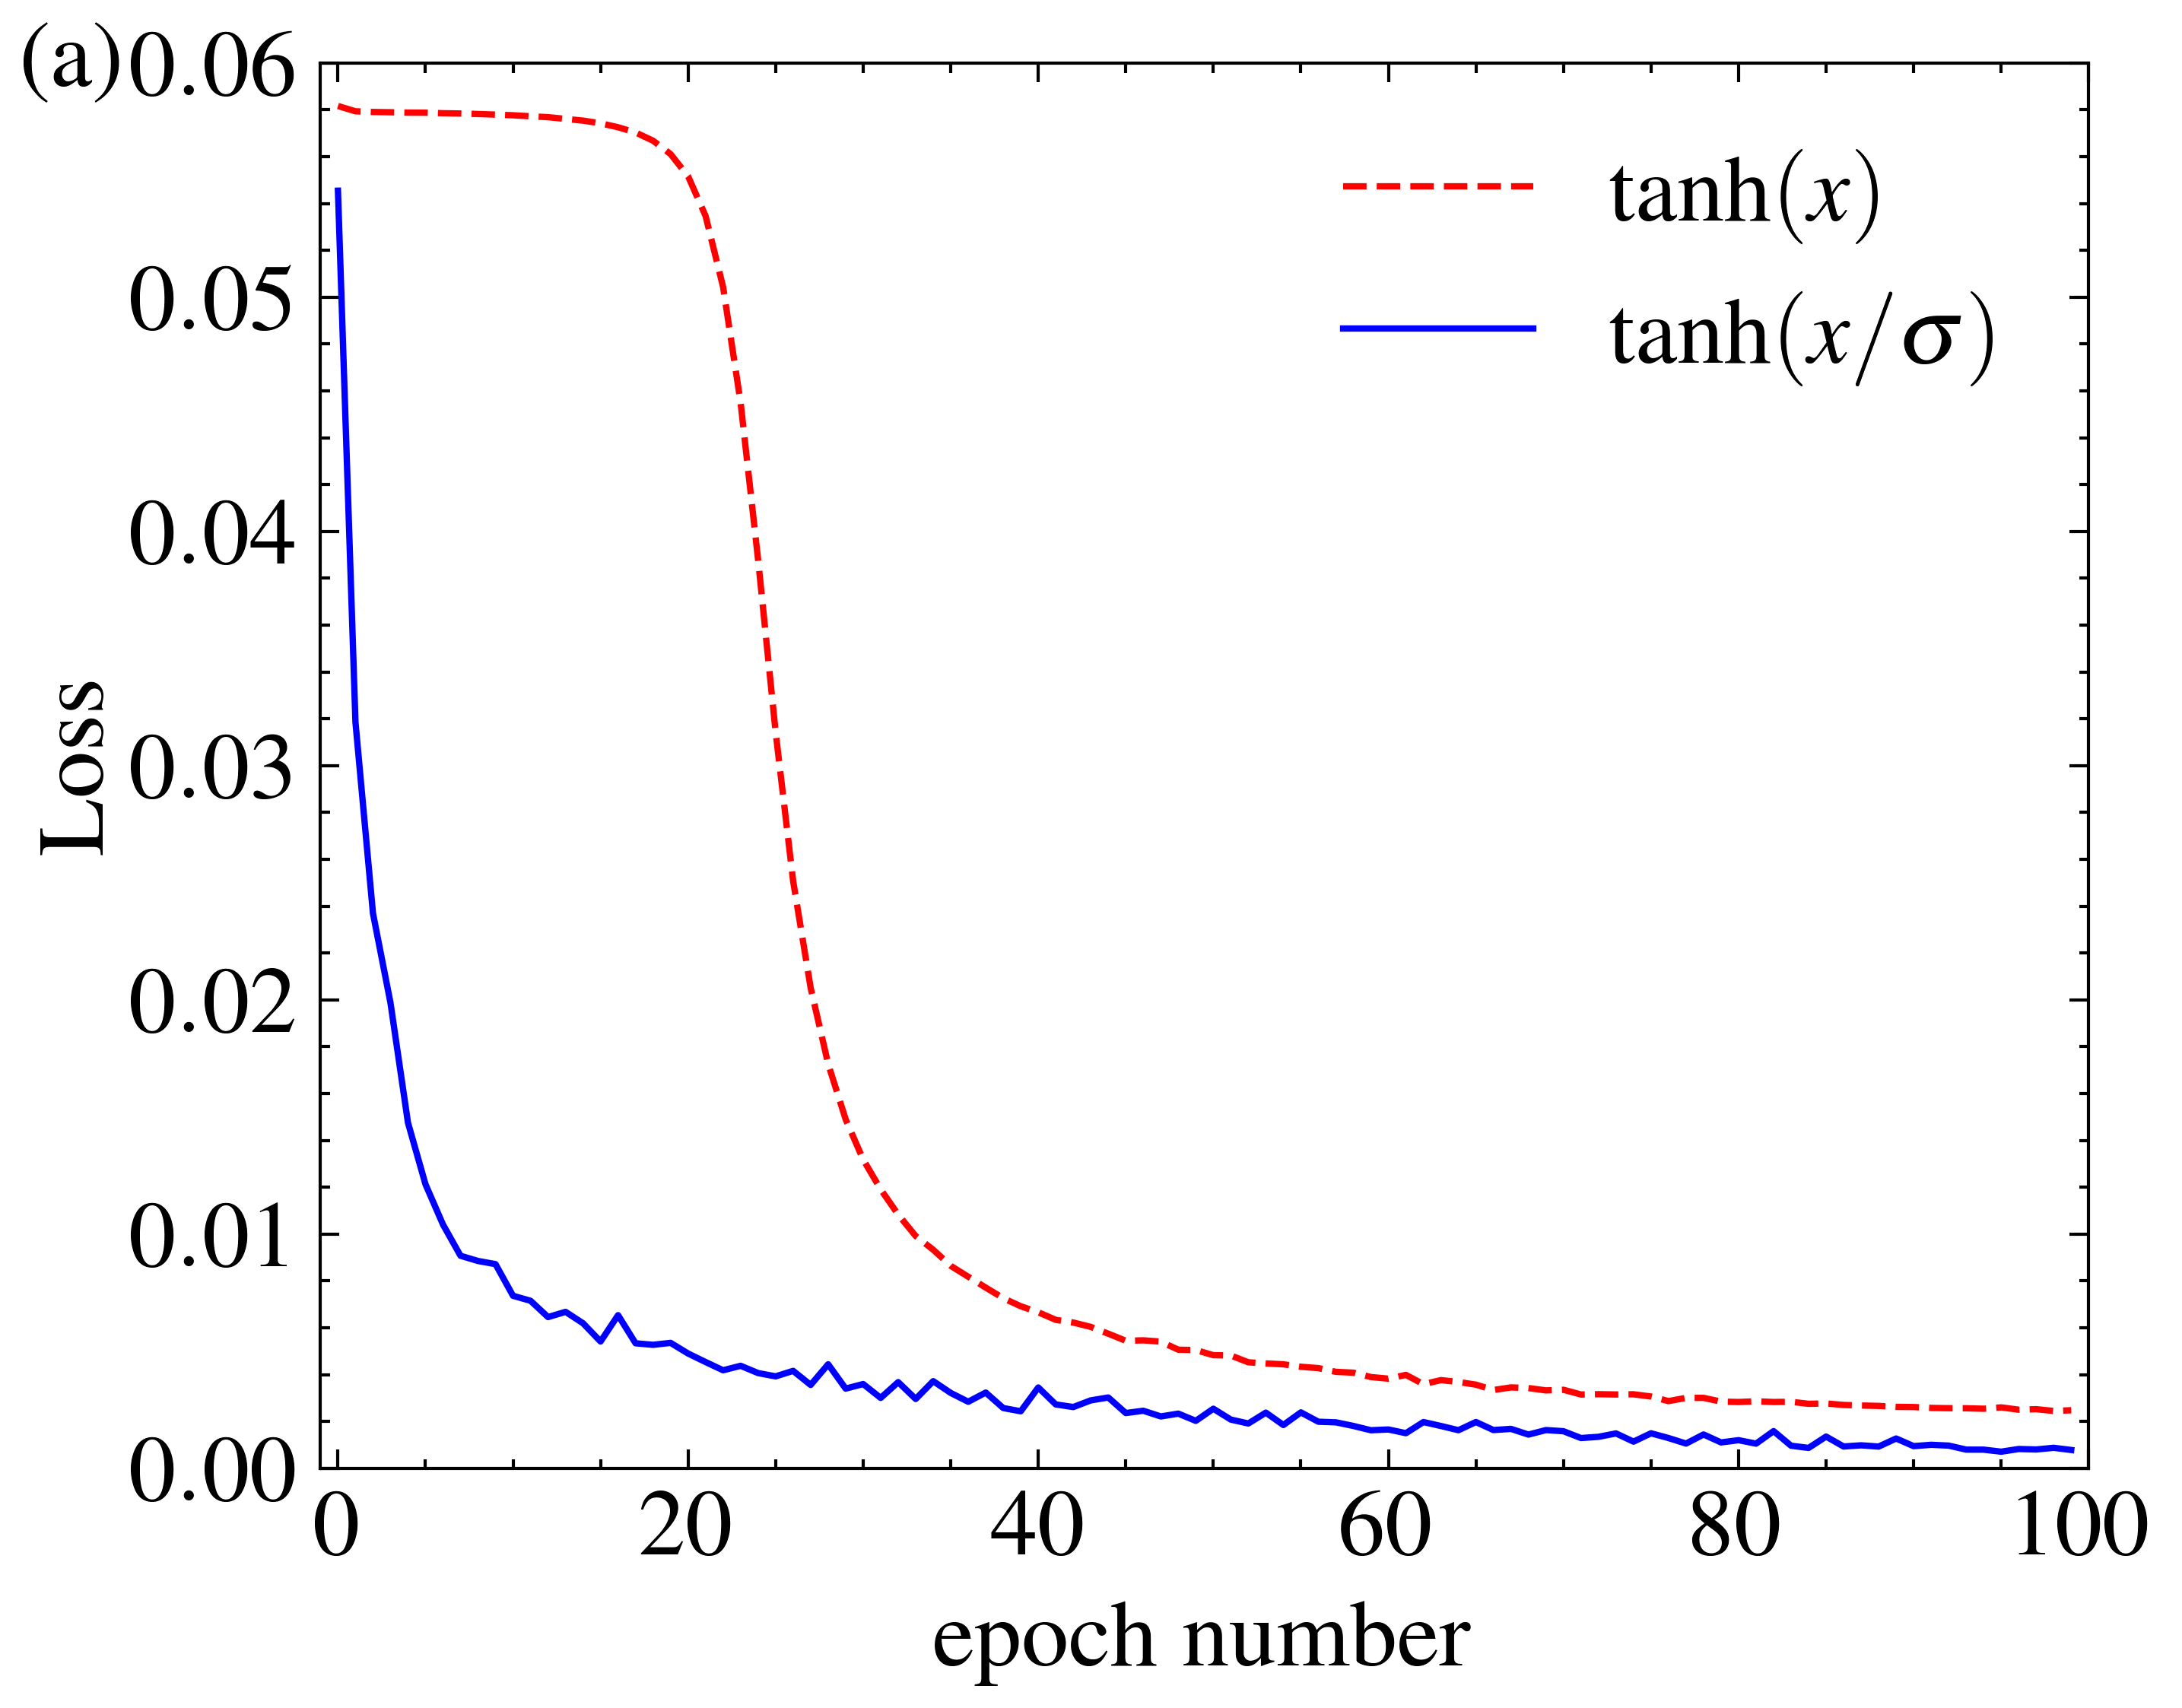

In [38]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
plt.rcParams ['font.serif'] = ['Times New Roman']
#plt.rcParams['font.family'] = 'STIX General'
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Combine elements
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb}'  # Combine elements
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('Loss', fontsize=15,labelpad = 1)
ax.set_xlim(-1, 100)
ax.set_ylim(0, 0.06)


# 将张量转换为NumPy数组，以便保存为CSV
numpy_tensor1 = tensor1tanh.numpy()
numpy_tensor2 = tensor2sigma.numpy()

# 保存为CSV文件
np.savetxt("D:/深度学习与信息论/tensor1tanh.csv", numpy_tensor1, delimiter=",")
np.savetxt("D:/深度学习与信息论/tensor2sigma.csv", numpy_tensor2, delimiter=",")

# 绘制曲线图
plt.plot(numpy_tensor1, 'r--', lw=1, label=r"${\rm tanh}(x)$")
plt.plot(numpy_tensor2,'b-', lw=1, label=r"${\rm tanh}(x/\sigma)$")

ax.text(-18, 0.059, '(a)',fontdict={'size': 15, 'color':  'black'})
ax.legend(loc='upper right', fontsize=15)
plt.show()

fig.savefig('D:/深度学习与信息论/Fig4a.eps', dpi=800)

In [2]:
tensorsigmavalue=torch.tensor([0.4775696396827698,
 0.45523807406425476,
 0.49669355154037476,
 0.46936434507369995,
 0.4769798517227173,
 0.4665120244026184,
 0.46355149149894714,
 0.45676934719085693,
 0.4681394696235657,
 0.460319459438324,
 0.43380340933799744,
 0.44467419385910034,
 0.4310326874256134,
 0.43690869212150574,
 0.432761013507843,
 0.420082151889801,
 0.4266801178455353,
 0.4246412217617035,
 0.4123592674732208,
 0.42974117398262024,
 0.4337100684642792,
 0.41432565450668335,
 0.4168270528316498,
 0.4127945303916931,
 0.3945782482624054,
 0.4081100821495056,
 0.4028775990009308,
 0.41386714577674866,
 0.3996778130531311,
 0.4019722044467926,
 0.3925187289714813,
 0.4014982283115387,
 0.40286949276924133,
 0.3960375189781189,
 0.39233896136283875,
 0.39851051568984985,
 0.3908550441265106,
 0.38824552297592163,
 0.38392123579978943,
 0.38232454657554626,
 0.38551852107048035,
 0.3769444227218628,
 0.37770289182662964,
 0.37270328402519226,
 0.37681475281715393,
 0.3790148198604584,
 0.3723297119140625,
 0.3679966330528259,
 0.36803048849105835,
 0.36786654591560364,
 0.3716917335987091,
 0.3667297959327698,
 0.36343488097190857,
 0.365848183631897,
 0.36096662282943726,
 0.359023779630661,
 0.3566606044769287,
 0.36045315861701965,
 0.3582399785518646,
 0.3553133010864258,
 0.3491442799568176,
 0.34789755940437317,
 0.34473052620887756,
 0.3481776714324951,
 0.35099026560783386,
 0.348868727684021,
 0.3492528796195984,
 0.3438340425491333,
 0.3458310067653656,
 0.34185317158699036,
 0.337554931640625,
 0.3362969756126404,
 0.3365638852119446,
 0.33357930183410645,
 0.3330463469028473,
 0.33229970932006836,
 0.334781289100647,
 0.33426278829574585,
 0.3305882215499878,
 0.32797226309776306,
 0.3267769515514374,
 0.3236132860183716,
 0.3216851055622101,
 0.3214033544063568,
 0.3209620714187622,
 0.32299894094467163,
 0.3230516016483307,
 0.321296751499176,
 0.31936725974082947,
 0.3171020448207855,
 0.3150888979434967,
 0.314342200756073,
 0.31312039494514465,
 0.31240344047546387,
 0.3107622563838959,
 0.30830225348472595,
 0.3071920871734619,
 0.3055473268032074,
 0.30534201860427856,
 0.3060045838356018])

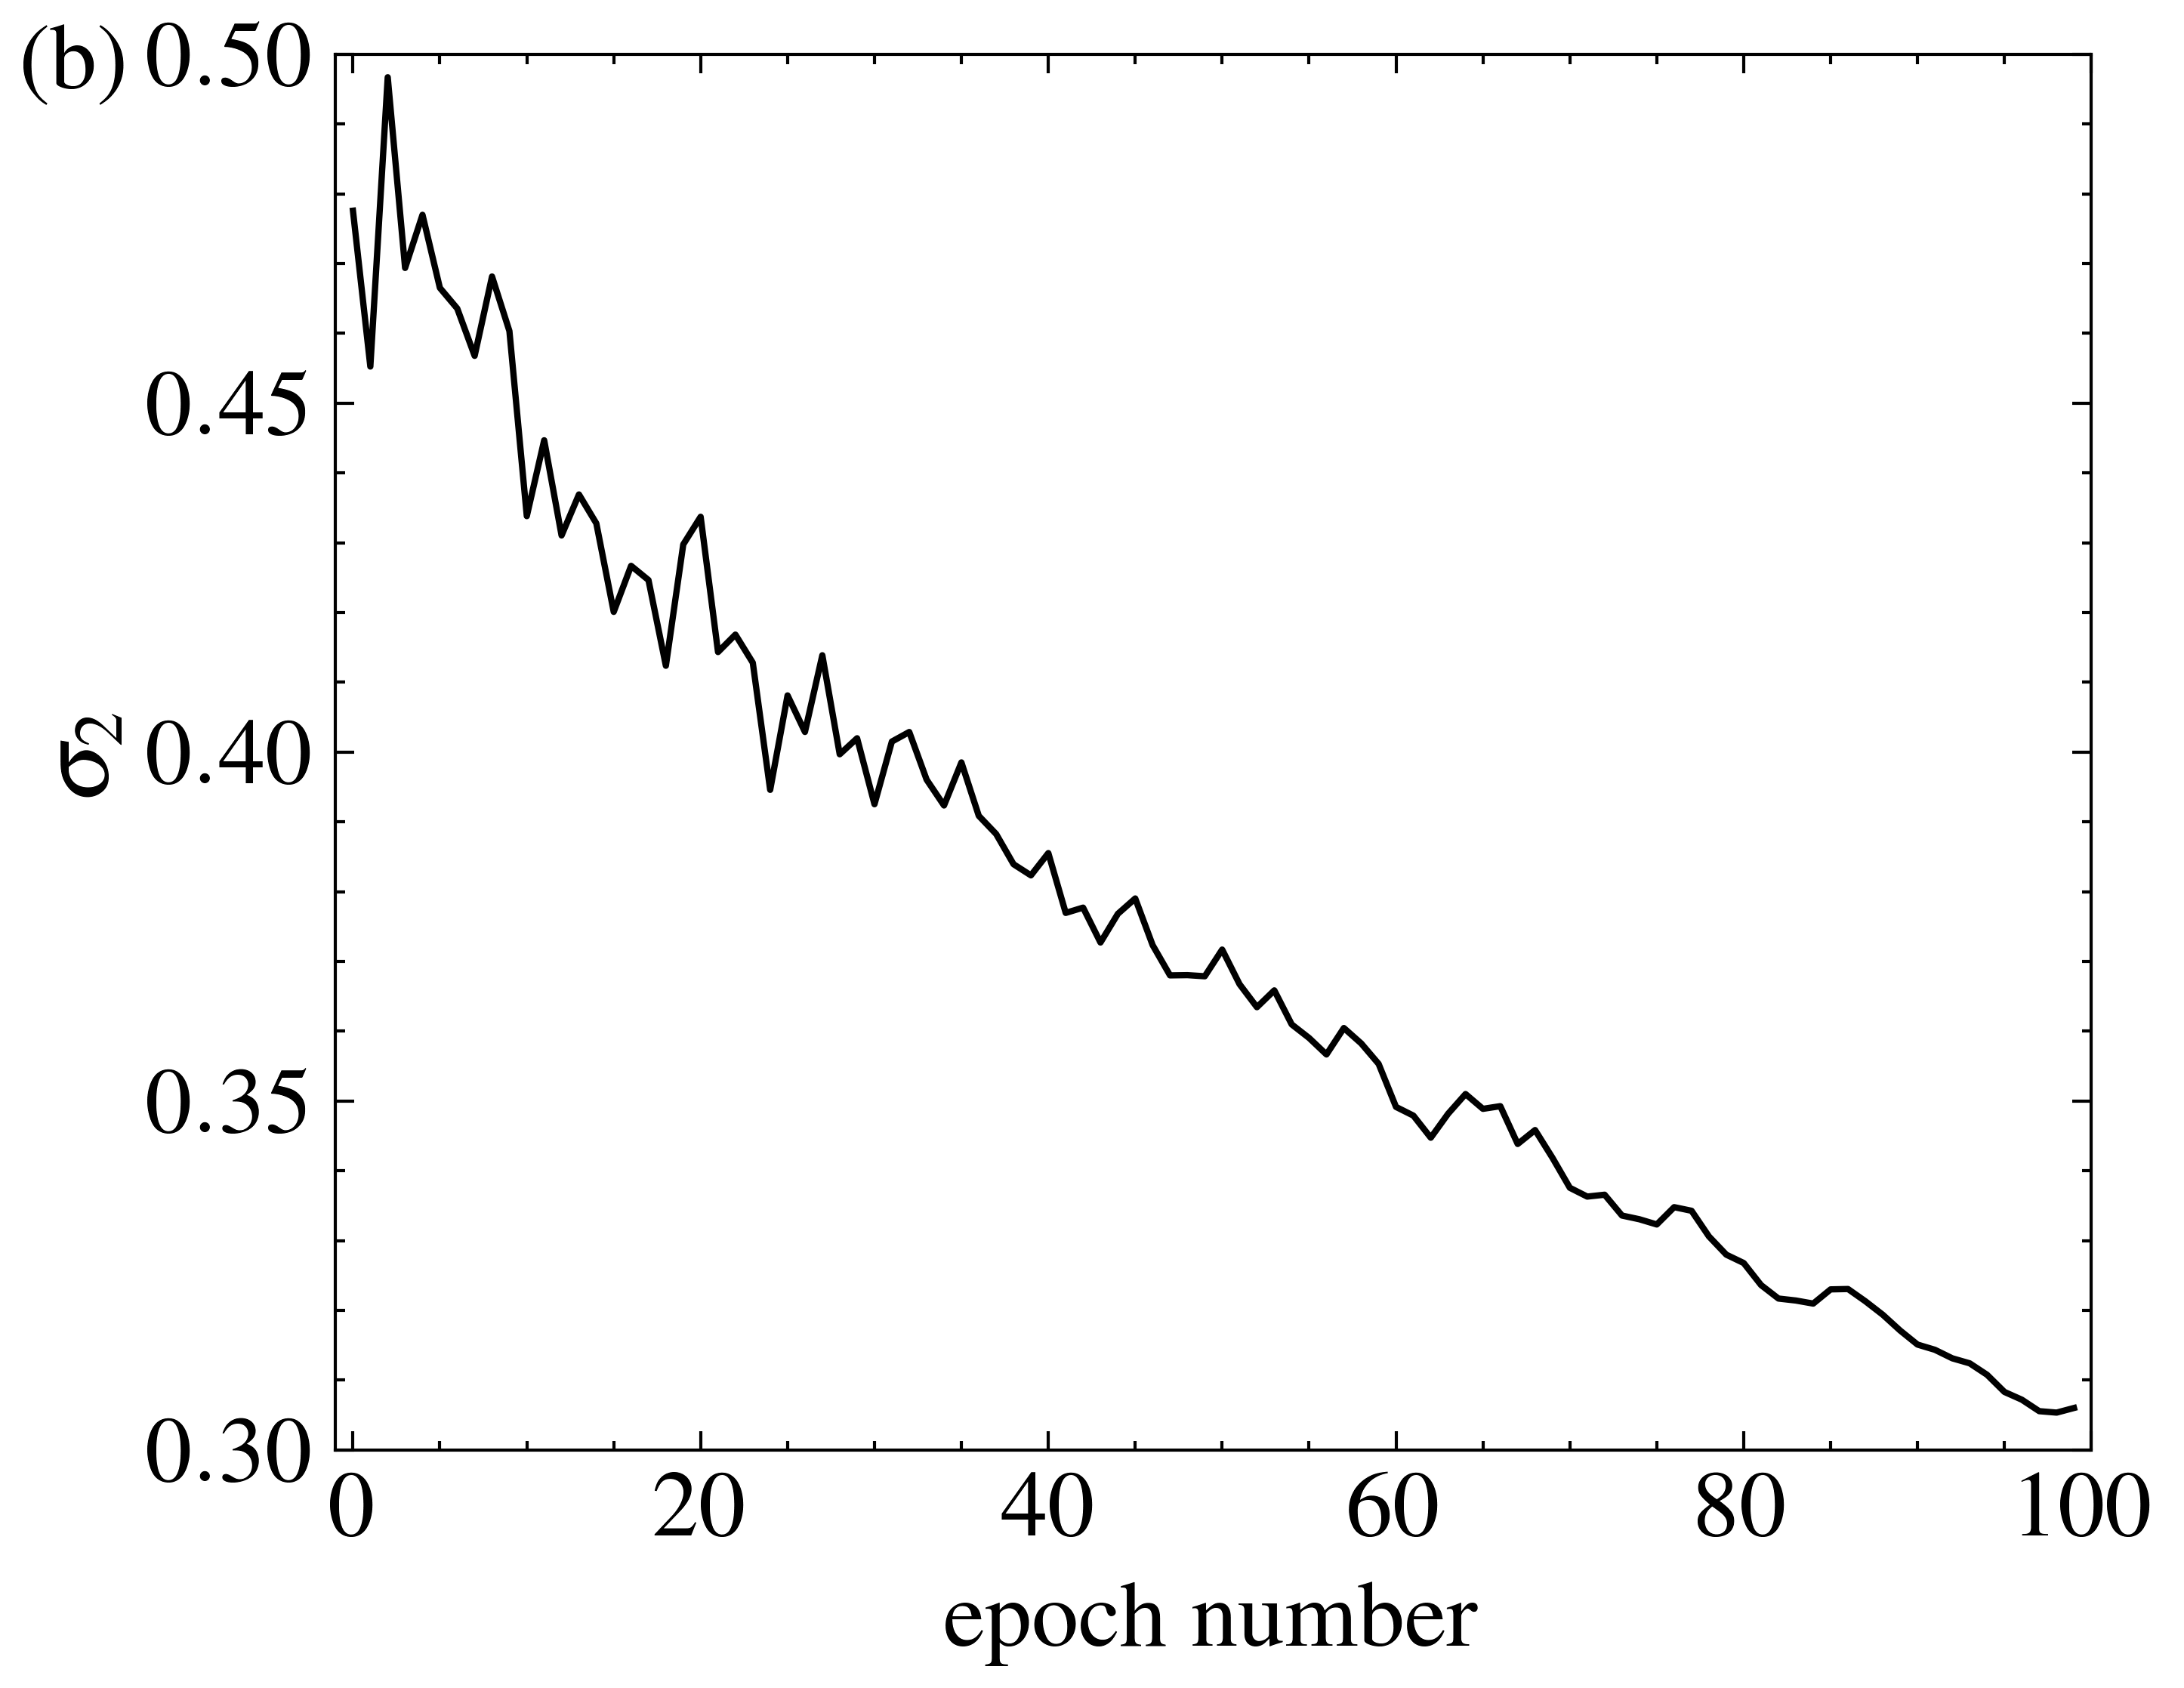

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
plt.rcParams ['font.serif'] = ['Times New Roman']
#plt.rcParams['font.family'] = 'STIX General'
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Combine elements
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb}'  # Combine elements
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel(r"$\sigma_2$", fontsize=15,labelpad = 3)
ax.set_xlim(-1, 100)
ax.set_ylim(0.3, 0.5)


# 将张量转换为NumPy数组，以便保存为CSV
numpy_tensor3 = tensorsigmavalue.numpy()

# 保存为CSV文件
np.savetxt("D:/深度学习与信息论/tensor1tanh.csv", numpy_tensor3, delimiter=",")

# 绘制曲线图
plt.plot(numpy_tensor3,'k-', lw=1)
ax.text(-19, 0.495, '(b)',fontdict={'size': 15, 'color':  'black'})
plt.show()

fig.savefig('D:/深度学习与信息论/Fig4b.eps', dpi=800)

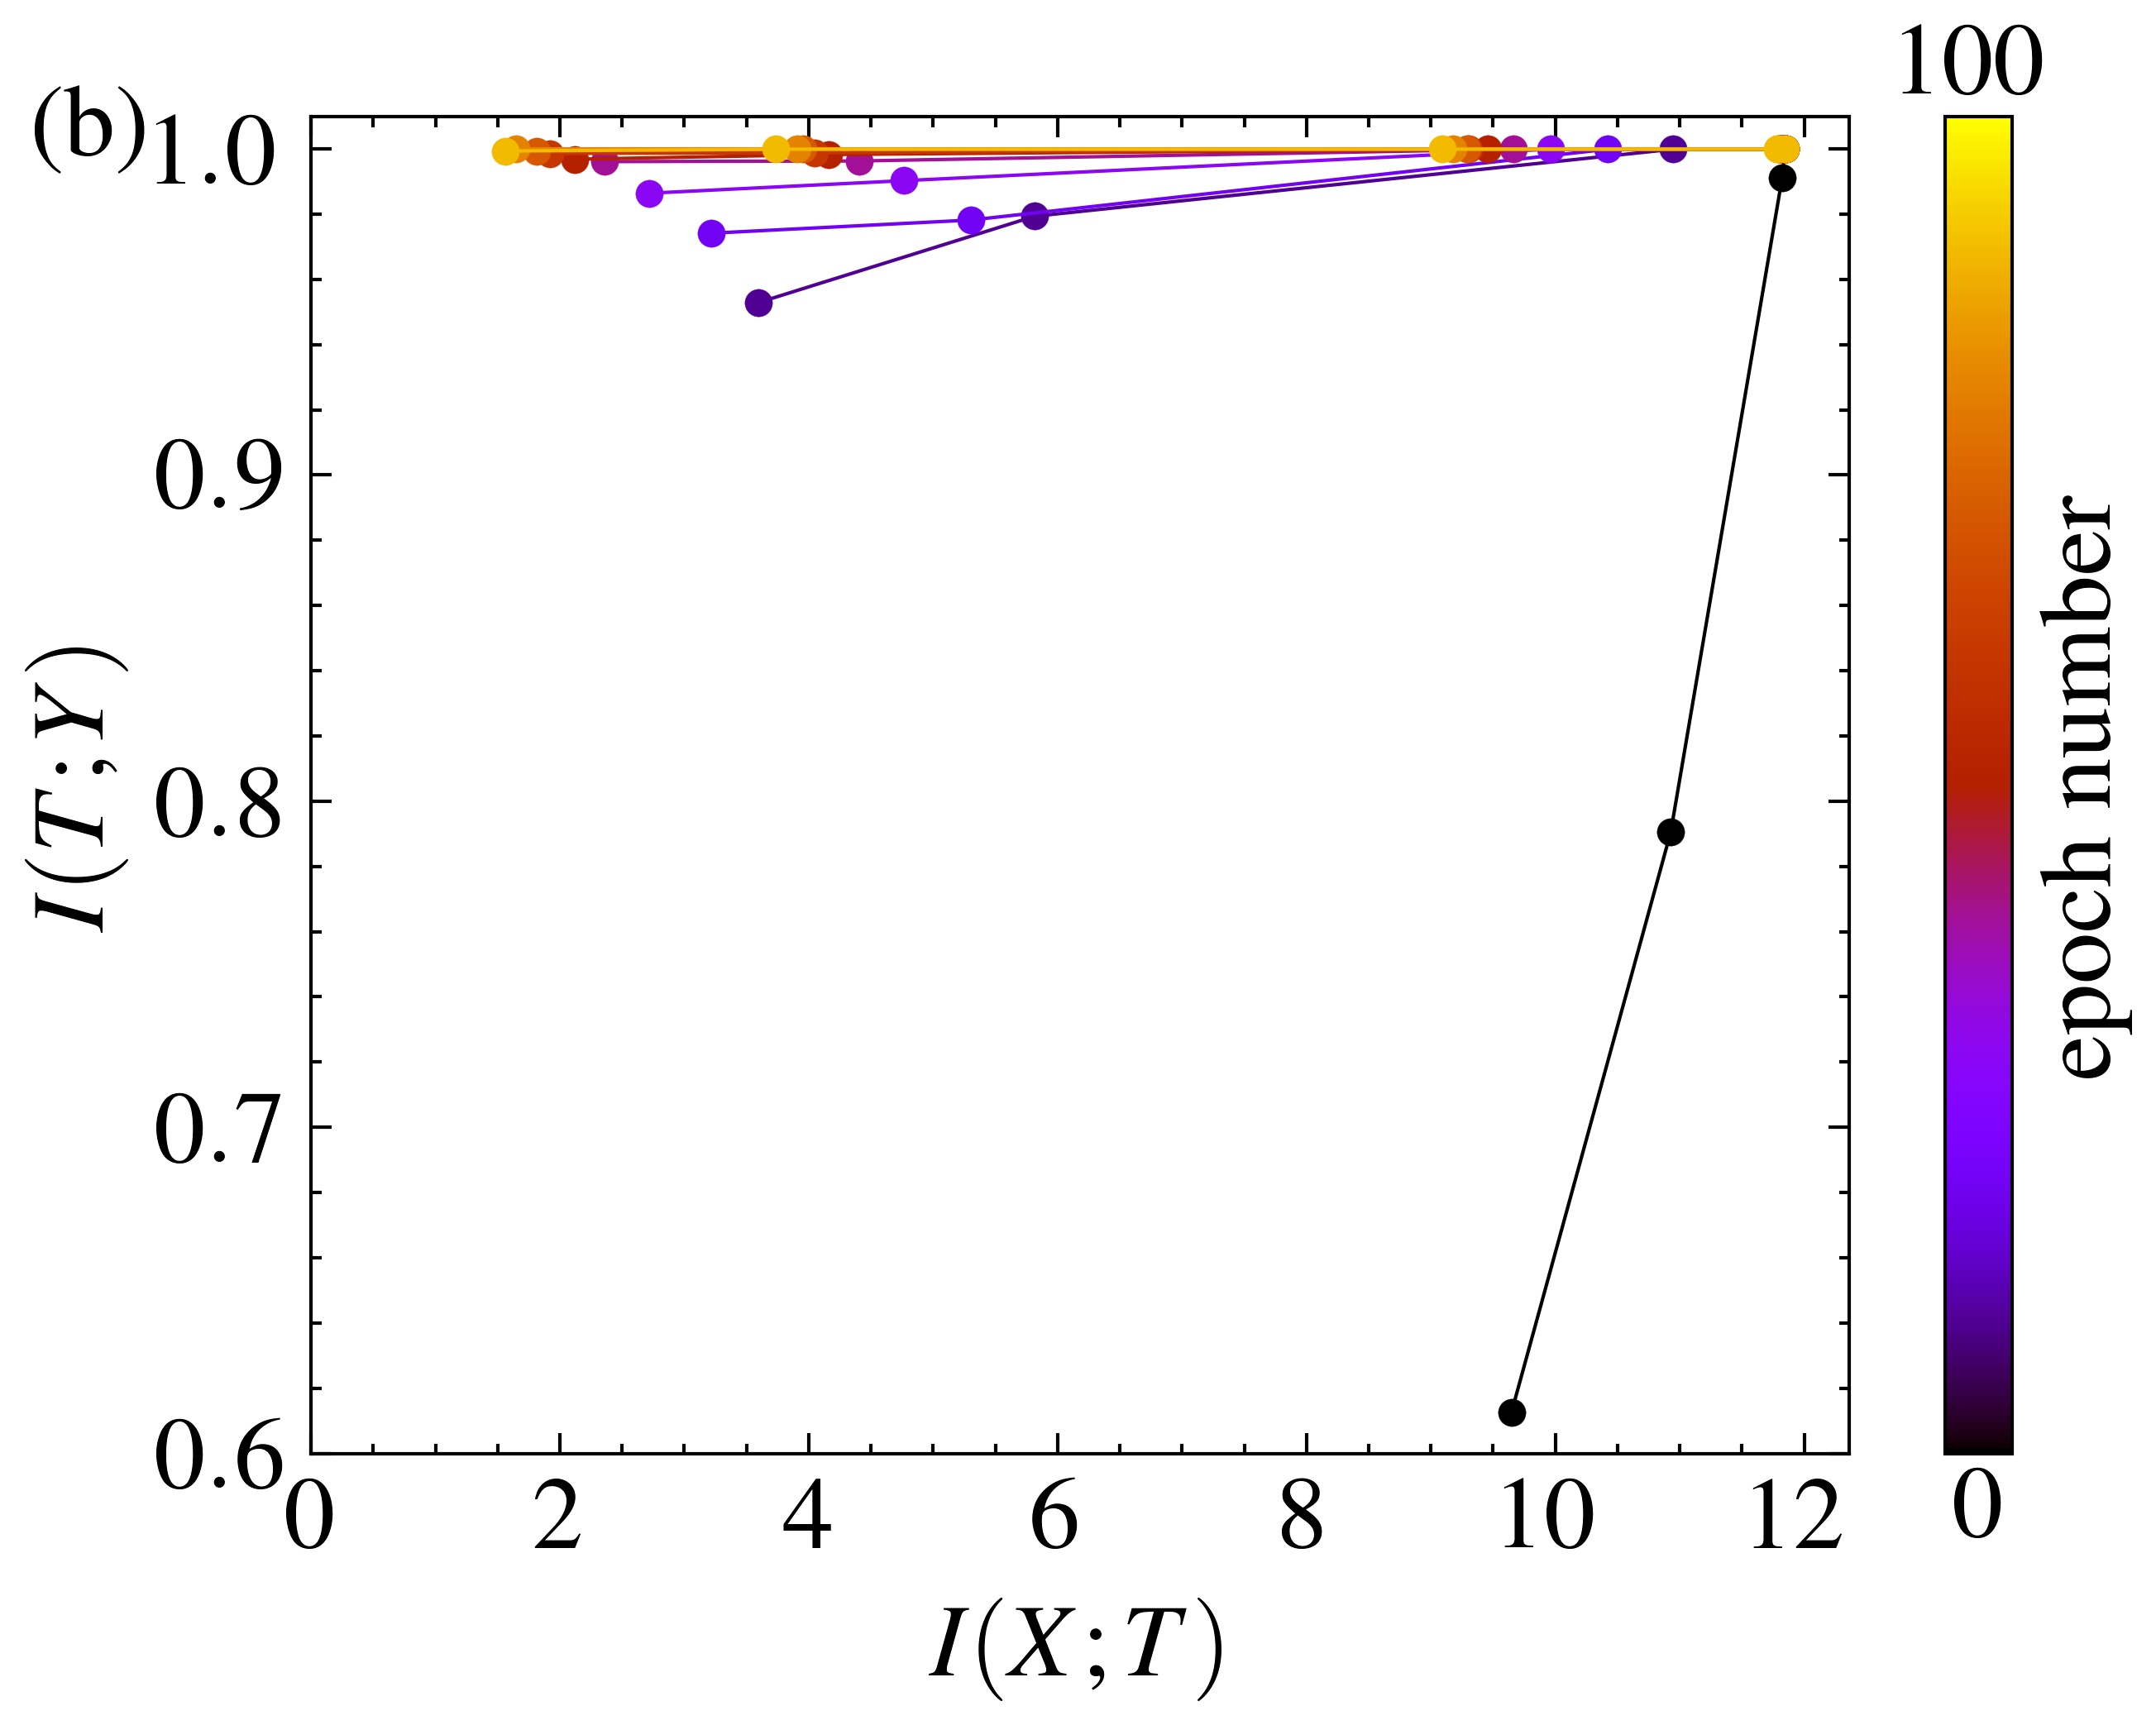

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        ax.plot(IXT, ITY, marker='o', markersize=4, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[i * every_n], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
    ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim(0.6, 1.01)  # 修改y轴坐标范围为0.6到1
    # Adjust coordinates of text according to the plot area
    ax.text(-0.18, 0.97, '(b)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/Fig5b.eps', dpi=800)
    plt.show()

# Assuming IXT_array, ITY_array, epochs, and every_n are defined here
plot_information_plane(IXT_array, ITY_array, num_epochs=epochs, every_n=every_n)


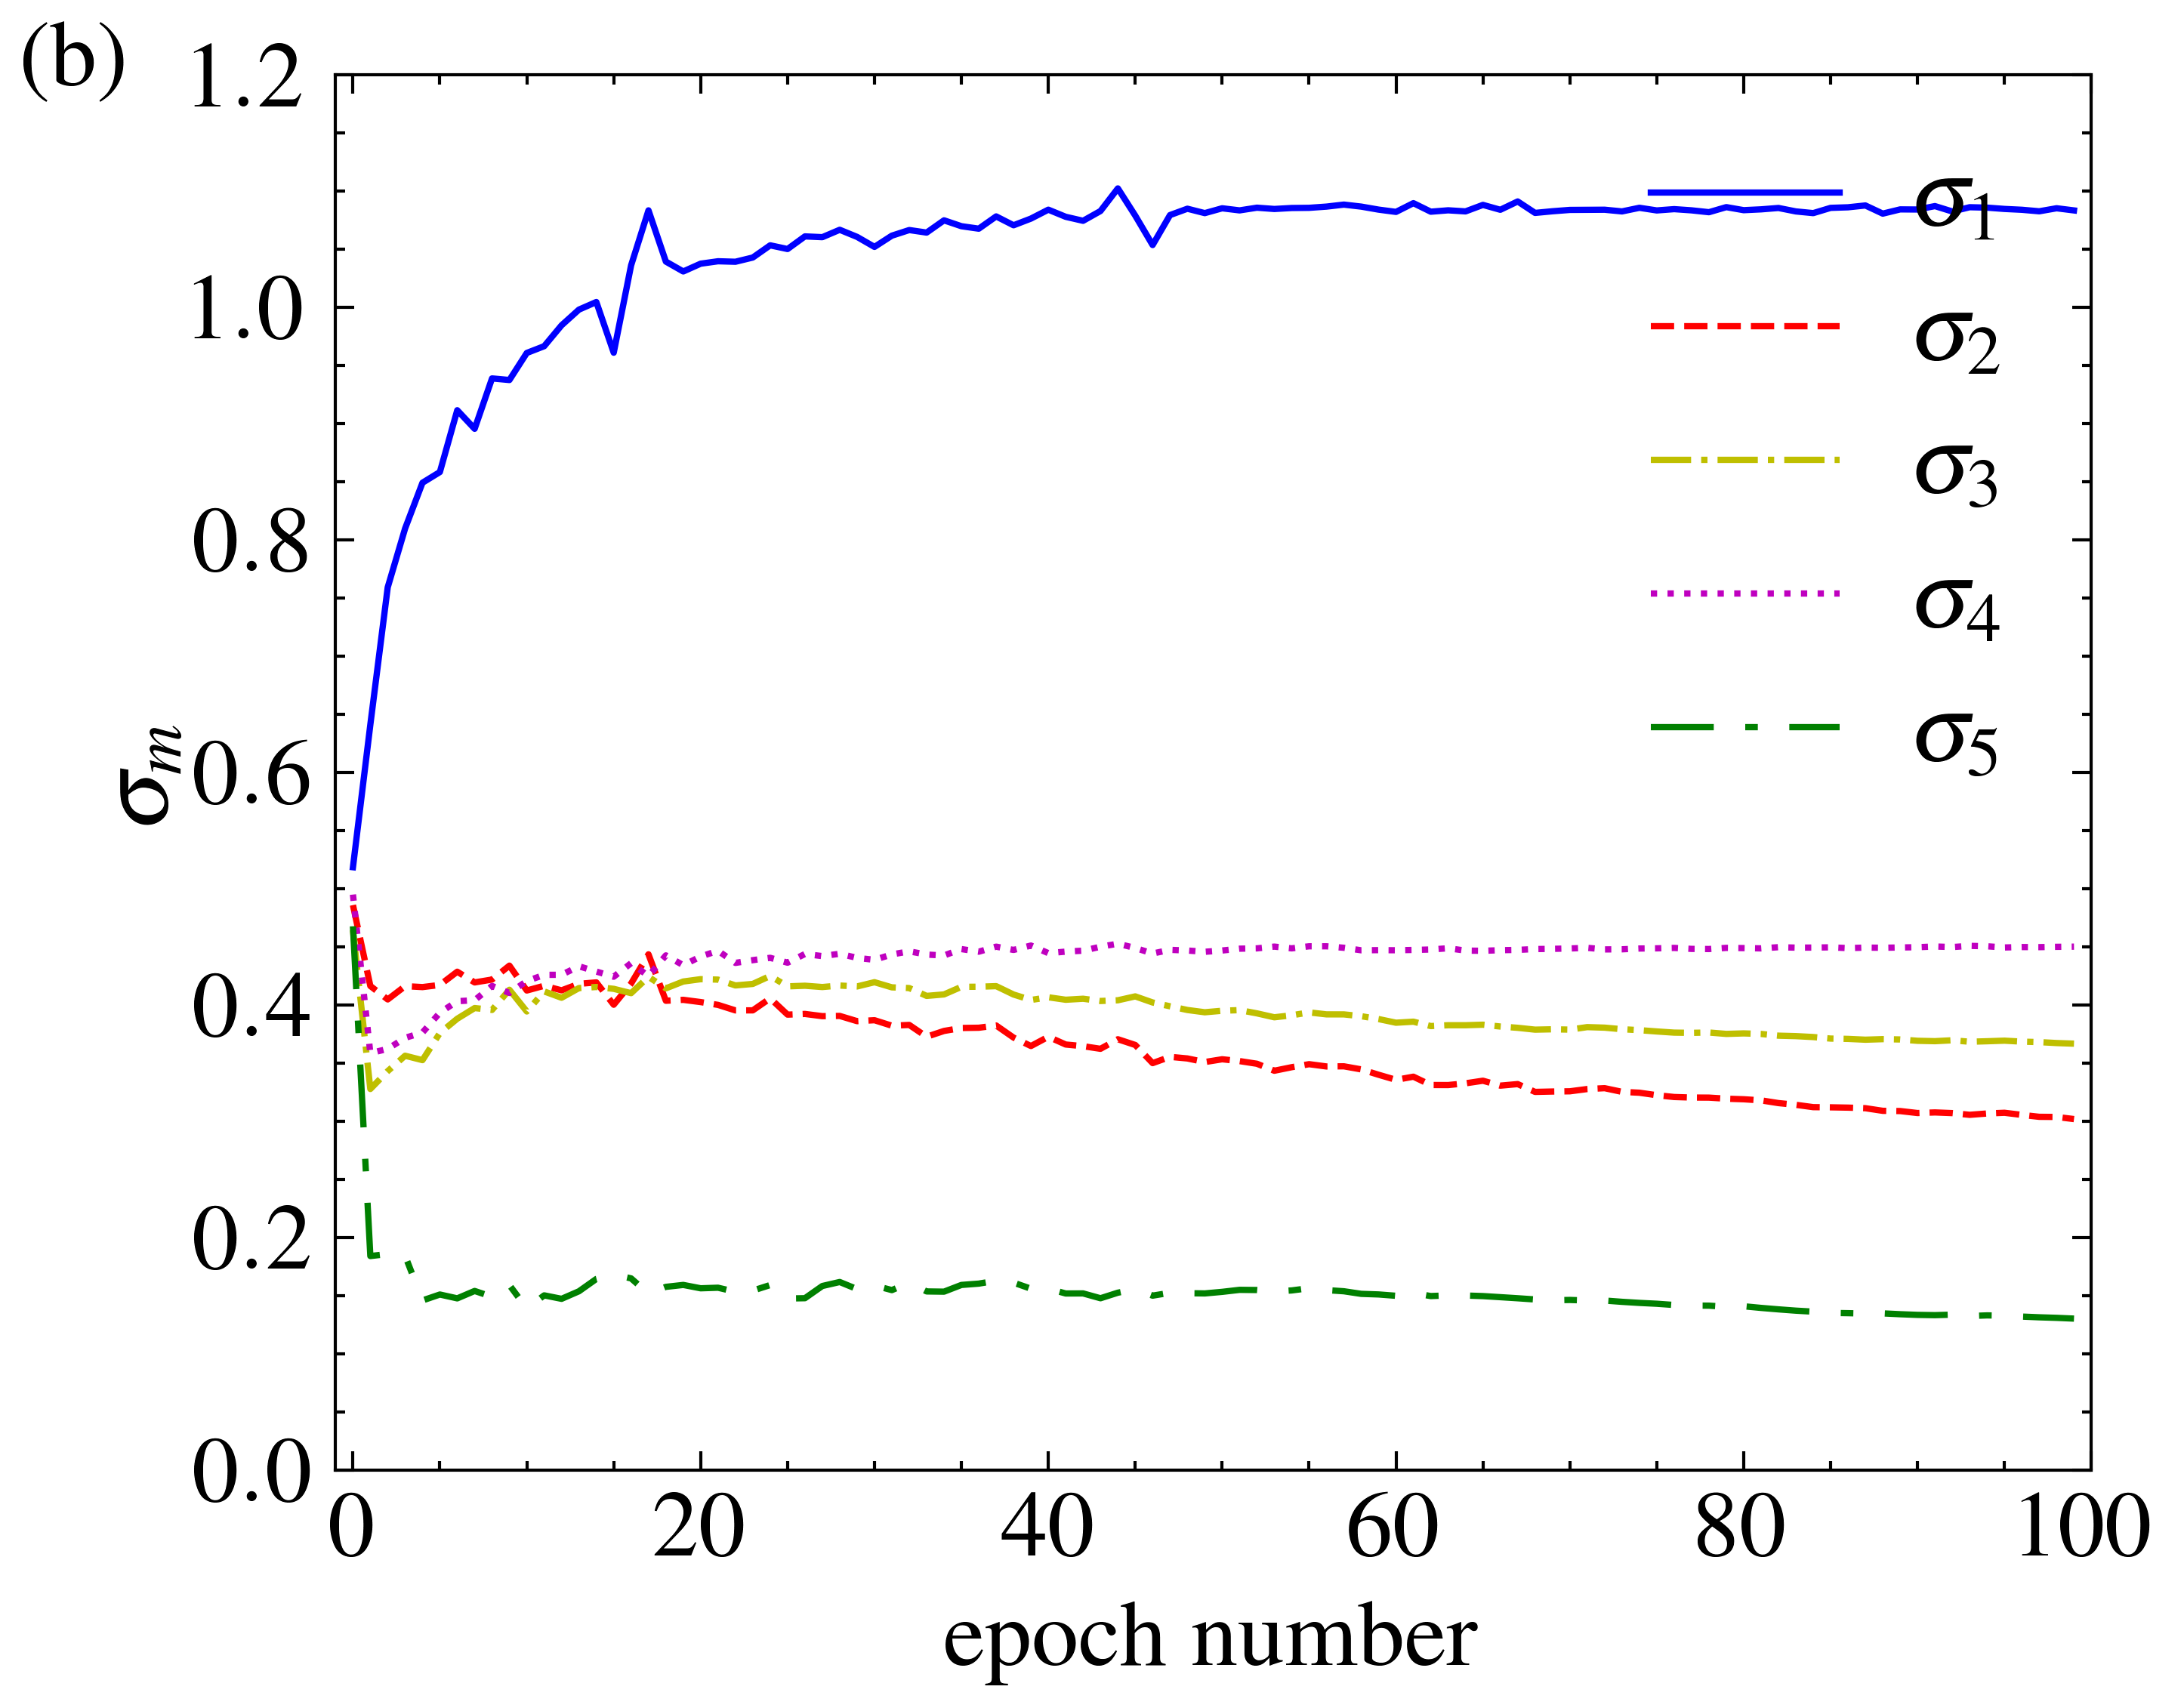

In [82]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('$\sigma_m$', fontsize=15,labelpad = 1)
ax.set_xlim(-1, 100)
ax.set_ylim(0, 1.2)

plt.plot(np.arange(len(train_res[3])), train_res[3], linestyle='-', color='b', lw=1, label='$\sigma_1$')  # 蓝色实线
plt.plot(np.arange(len(train_res[4])), train_res[4], linestyle='--', color='r', lw=1, label='$\sigma_2$')  # 红色虚线
plt.plot(np.arange(len(train_res[5])), train_res[5], linestyle='-.', color='y', lw=1, label='$\sigma_3$')  # 黄色点划线
plt.plot(np.arange(len(train_res[6])), train_res[6], linestyle=':', color='m', lw=1, label='$\sigma_4$')  # 紫色点线
plt.plot(np.arange(len(train_res[7])), train_res[7], color='g', lw=1, label='$\sigma_5$')  # 自定义虚线
plt.gca().lines[-1].set_dashes([10, 5, 2, 5])  # 设置虚线的长度和间距
ax.legend(loc='upper right', fontsize=15)
ax.text(-19, 1.19, '(b)',fontdict={'size': 15, 'color':  'black'})
fig.savefig('D:/深度学习与信息论/Fig4b.eps', dpi=800)
plt.show()